# Setup

**Imports**

In [ ]:
import datetime as dt
from math import log
import IPython
import geopandas
import contextily as cx
from math import asin, cos, radians, sin, sqrt


from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.fft import fft
from pygsp import graphs
from scipy.spatial.distance import pdist, squareform
from scipy.signal import stft
from sklearn.cluster import KMeans

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [ ]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

STFT shape: (129, 154)
Energy per frequency shape: (129,)
Frequency bins: 129, Time frames: 154


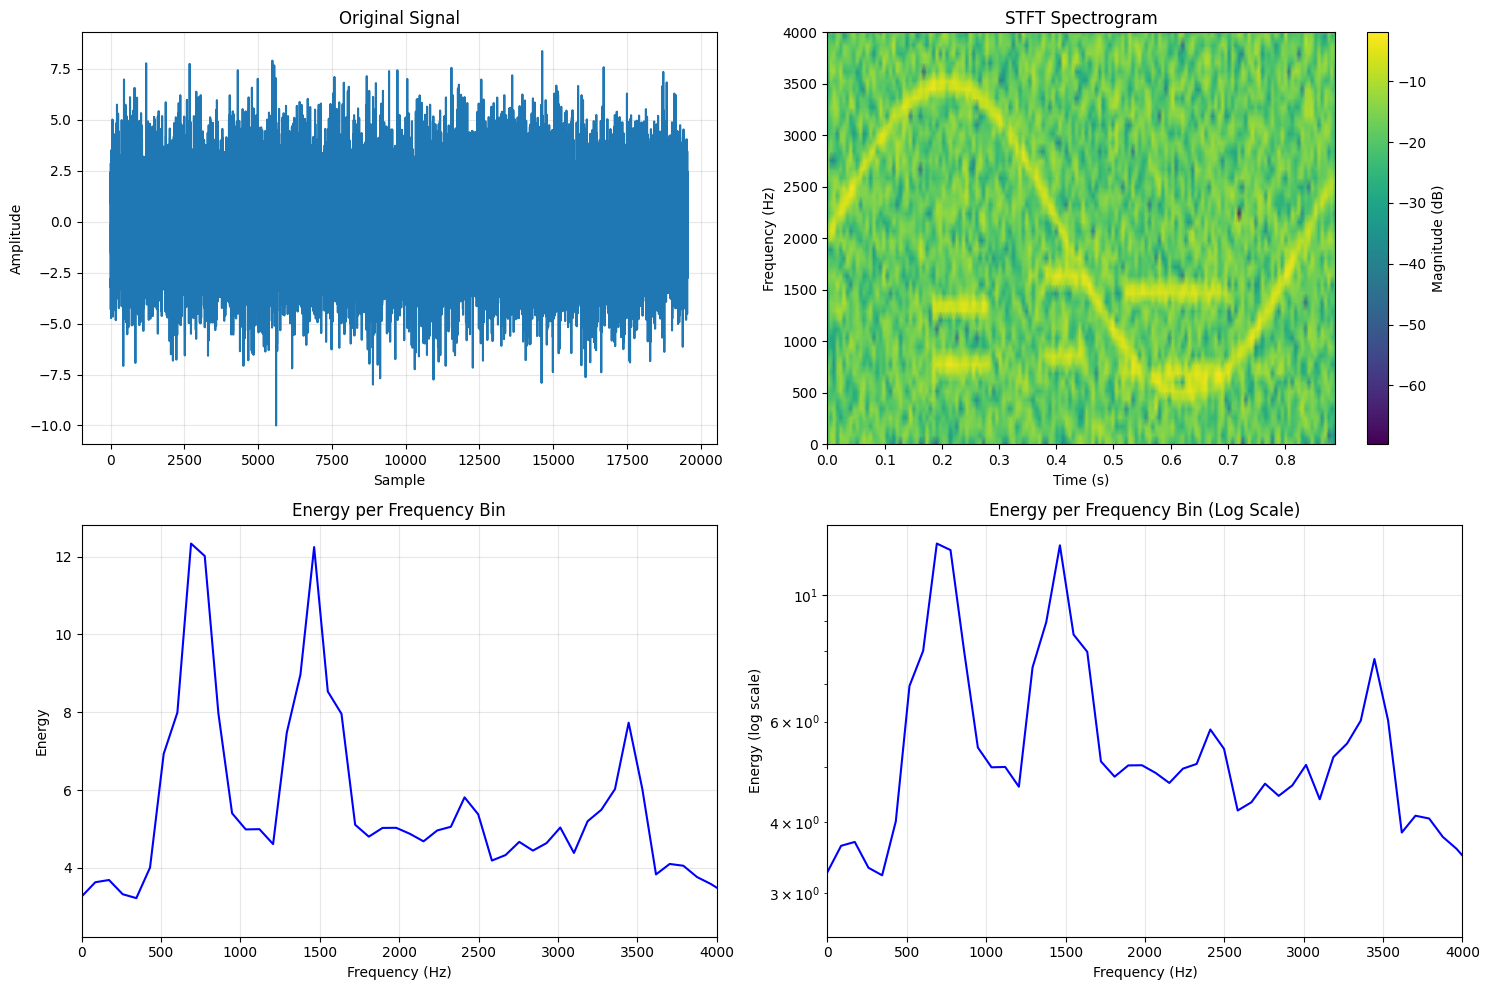

In [ ]:
# Cell 1: STFT and energy computation
# we compute the STFT to obtain the time-frequency representation
# for each frequency bin, we compute the energy by integrating over the time axis

signal = X_train[0]  # example signal
window_length = 256
overlap = window_length // 2

# compute STFT
f, t, Zxx = stft(signal, fs=FS, nperseg=window_length, noverlap=overlap)

# compute energy for each frequency bin by integrating over time
energy_per_freq = np.sum(np.abs(Zxx)**2, axis=1)  # shape: (n_freq,)

print(f"STFT shape: {Zxx.shape}")
print(f"Energy per frequency shape: {energy_per_freq.shape}")
print(f"Frequency bins: {len(f)}, Time frames: {len(t)}")

# visualization: STFT spectrogram and energy distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# plot 1: original signal
axes[0, 0].plot(signal)
axes[0, 0].set_title("Original Signal")
axes[0, 0].set_xlabel("Sample")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].grid(True, alpha=0.3)

# plot 2: STFT spectrogram
spectrogram = np.abs(Zxx)
im1 = axes[0, 1].pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), 
                            shading='gouraud', cmap='viridis')
axes[0, 1].set_title("STFT Spectrogram")
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Frequency (Hz)")
axes[0, 1].set_ylim([0, 4000])  # focus on DTMF frequency range
plt.colorbar(im1, ax=axes[0, 1], label="Magnitude (dB)")

# plot 3: energy per frequency bin
axes[1, 0].plot(f, energy_per_freq, 'b-', linewidth=1.5)
axes[1, 0].set_title("Energy per Frequency Bin")
axes[1, 0].set_xlabel("Frequency (Hz)")
axes[1, 0].set_ylabel("Energy")
axes[1, 0].set_xlim([0, 4000])
axes[1, 0].grid(True, alpha=0.3)

# plot 4: energy per frequency (log scale)
axes[1, 1].semilogy(f, energy_per_freq, 'b-', linewidth=1.5)
axes[1, 1].set_title("Energy per Frequency Bin (Log Scale)")
axes[1, 1].set_xlabel("Frequency (Hz)")
axes[1, 1].set_ylabel("Energy (log scale)")
axes[1, 1].set_xlim([0, 4000])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Total frequency bins: 129
High-energy (signal) bins: 11
Noise bins: 118
Signal cluster center energy: 9.11e+00
Noise cluster center energy: 3.96e+00


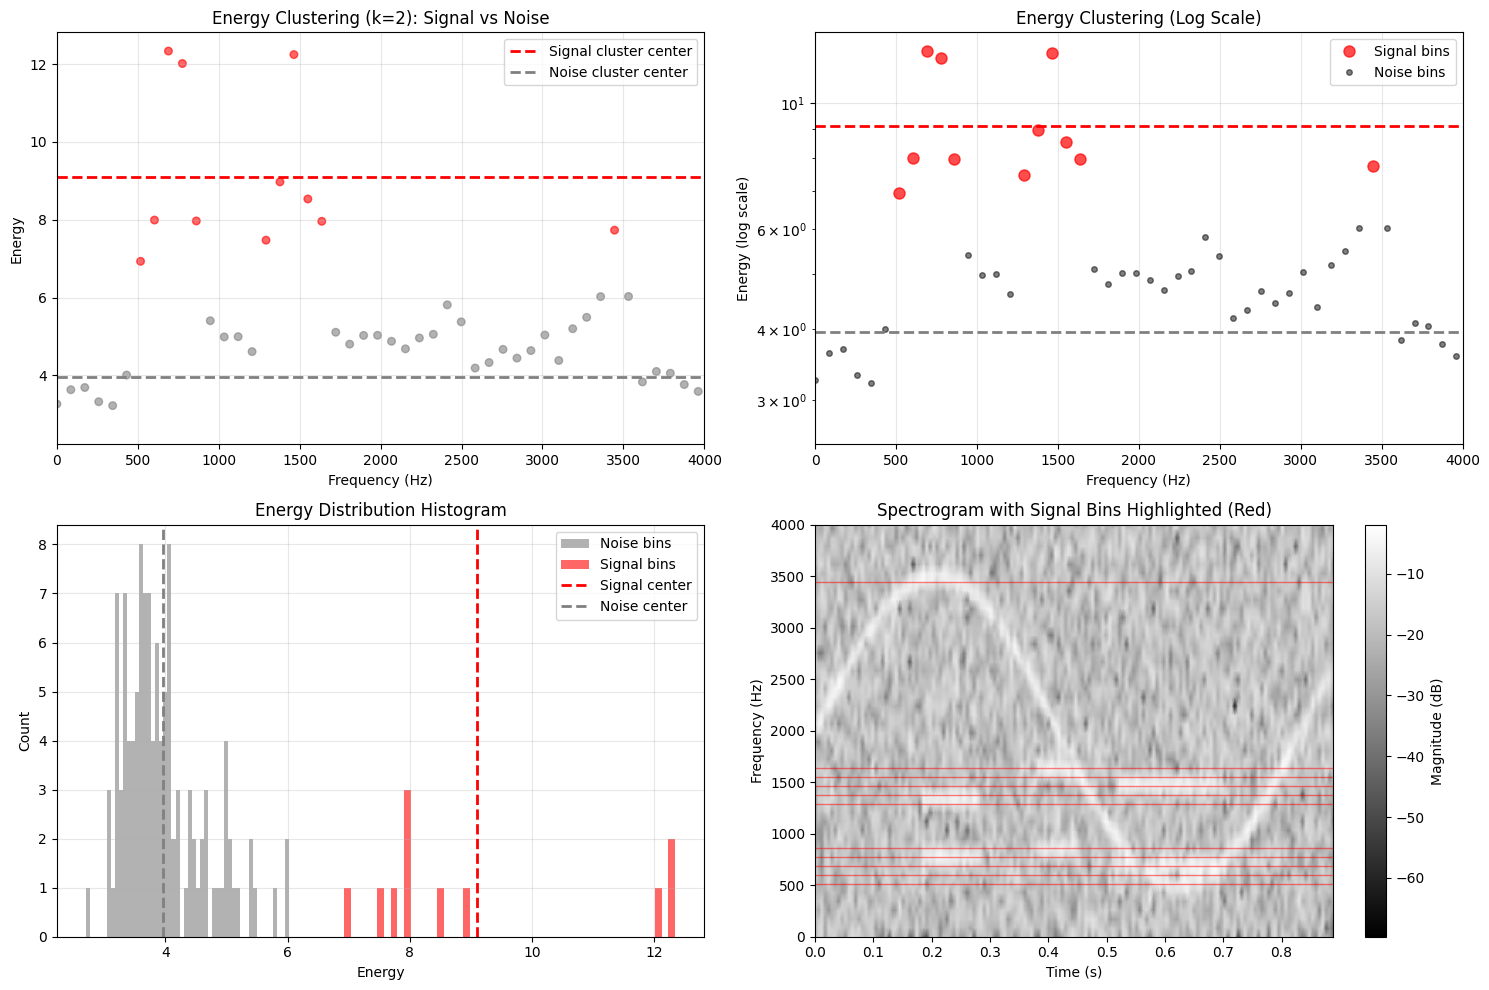

In [ ]:
# Cell 2: First k-means (k=2) to separate signal from noise
# we perform k-means clustering on the energy values to separate frequency bins 
# with high energy (signal) from those with low energy (noise)

# reshape energy for k-means
energy_reshaped = energy_per_freq.reshape(-1, 1)

# k-means with k=2 to separate signal from noise
kmeans_energy = KMeans(n_clusters=2, random_state=0, n_init=10)
energy_labels = kmeans_energy.fit_predict(energy_reshaped)

# identify which cluster has higher energy (signal cluster)
cluster_centers = kmeans_energy.cluster_centers_.flatten()
signal_cluster_idx = np.argmax(cluster_centers)
noise_cluster_idx = 1 - signal_cluster_idx

# get frequency bins that belong to signal cluster
high_energy_freq_indices = np.where(energy_labels == signal_cluster_idx)[0]
high_energy_freqs = f[high_energy_freq_indices]

print(f"Total frequency bins: {len(f)}")
print(f"High-energy (signal) bins: {len(high_energy_freq_indices)}")
print(f"Noise bins: {len(f) - len(high_energy_freq_indices)}")
print(f"Signal cluster center energy: {cluster_centers[signal_cluster_idx]:.2e}")
print(f"Noise cluster center energy: {cluster_centers[noise_cluster_idx]:.2e}")

# visualization: energy clustering results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# plot 1: energy distribution with cluster assignment
colors = ['red' if label == signal_cluster_idx else 'gray' 
          for label in energy_labels]
axes[0, 0].scatter(f, energy_per_freq, c=colors, alpha=0.6, s=30)
axes[0, 0].axhline(y=cluster_centers[signal_cluster_idx], 
                   color='red', linestyle='--', linewidth=2, label='Signal cluster center')
axes[0, 0].axhline(y=cluster_centers[noise_cluster_idx], 
                   color='gray', linestyle='--', linewidth=2, label='Noise cluster center')
axes[0, 0].set_title("Energy Clustering (k=2): Signal vs Noise")
axes[0, 0].set_xlabel("Frequency (Hz)")
axes[0, 0].set_ylabel("Energy")
axes[0, 0].set_xlim([0, 4000])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# plot 2: energy distribution (log scale) with clusters
axes[0, 1].semilogy(f[energy_labels == signal_cluster_idx], 
                    energy_per_freq[energy_labels == signal_cluster_idx], 
                    'ro', markersize=8, alpha=0.7, label='Signal bins')
axes[0, 1].semilogy(f[energy_labels == noise_cluster_idx], 
                    energy_per_freq[energy_labels == noise_cluster_idx], 
                    'ko', markersize=4, alpha=0.5, label='Noise bins')
axes[0, 1].axhline(y=cluster_centers[signal_cluster_idx], 
                   color='red', linestyle='--', linewidth=2)
axes[0, 1].axhline(y=cluster_centers[noise_cluster_idx], 
                   color='gray', linestyle='--', linewidth=2)
axes[0, 1].set_title("Energy Clustering (Log Scale)")
axes[0, 1].set_xlabel("Frequency (Hz)")
axes[0, 1].set_ylabel("Energy (log scale)")
axes[0, 1].set_xlim([0, 4000])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# plot 3: histogram of energy values with cluster centers
axes[1, 0].hist(energy_per_freq[energy_labels == noise_cluster_idx], 
                bins=50, alpha=0.6, color='gray', label='Noise bins')
axes[1, 0].hist(energy_per_freq[energy_labels == signal_cluster_idx], 
                bins=50, alpha=0.6, color='red', label='Signal bins')
axes[1, 0].axvline(x=cluster_centers[signal_cluster_idx], 
                   color='red', linestyle='--', linewidth=2, label='Signal center')
axes[1, 0].axvline(x=cluster_centers[noise_cluster_idx], 
                   color='gray', linestyle='--', linewidth=2, label='Noise center')
axes[1, 0].set_title("Energy Distribution Histogram")
axes[1, 0].set_xlabel("Energy")
axes[1, 0].set_ylabel("Count")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# plot 4: spectrogram highlighting signal vs noise bins
spectrogram = np.abs(Zxx)
im = axes[1, 1].pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), 
                           shading='gouraud', cmap='gray')
# highlight signal bins
for idx in high_energy_freq_indices:
    axes[1, 1].axhline(y=f[idx], color='red', linewidth=1, alpha=0.5)
axes[1, 1].set_title("Spectrogram with Signal Bins Highlighted (Red)")
axes[1, 1].set_xlabel("Time (s)")
axes[1, 1].set_ylabel("Frequency (Hz)")
axes[1, 1].set_ylim([0, 4000])
plt.colorbar(im, ax=axes[1, 1], label="Magnitude (dB)")

plt.tight_layout()
plt.show()

Number of major frequency clusters (after filtering): 3
Cluster 0: center=732.1 Hz, energy=1.22e+01, n_bins=2
Cluster 1: center=732.1 Hz, energy=7.98e+00, n_bins=2
Cluster 2: center=1464.3 Hz, energy=8.75e+00, n_bins=2


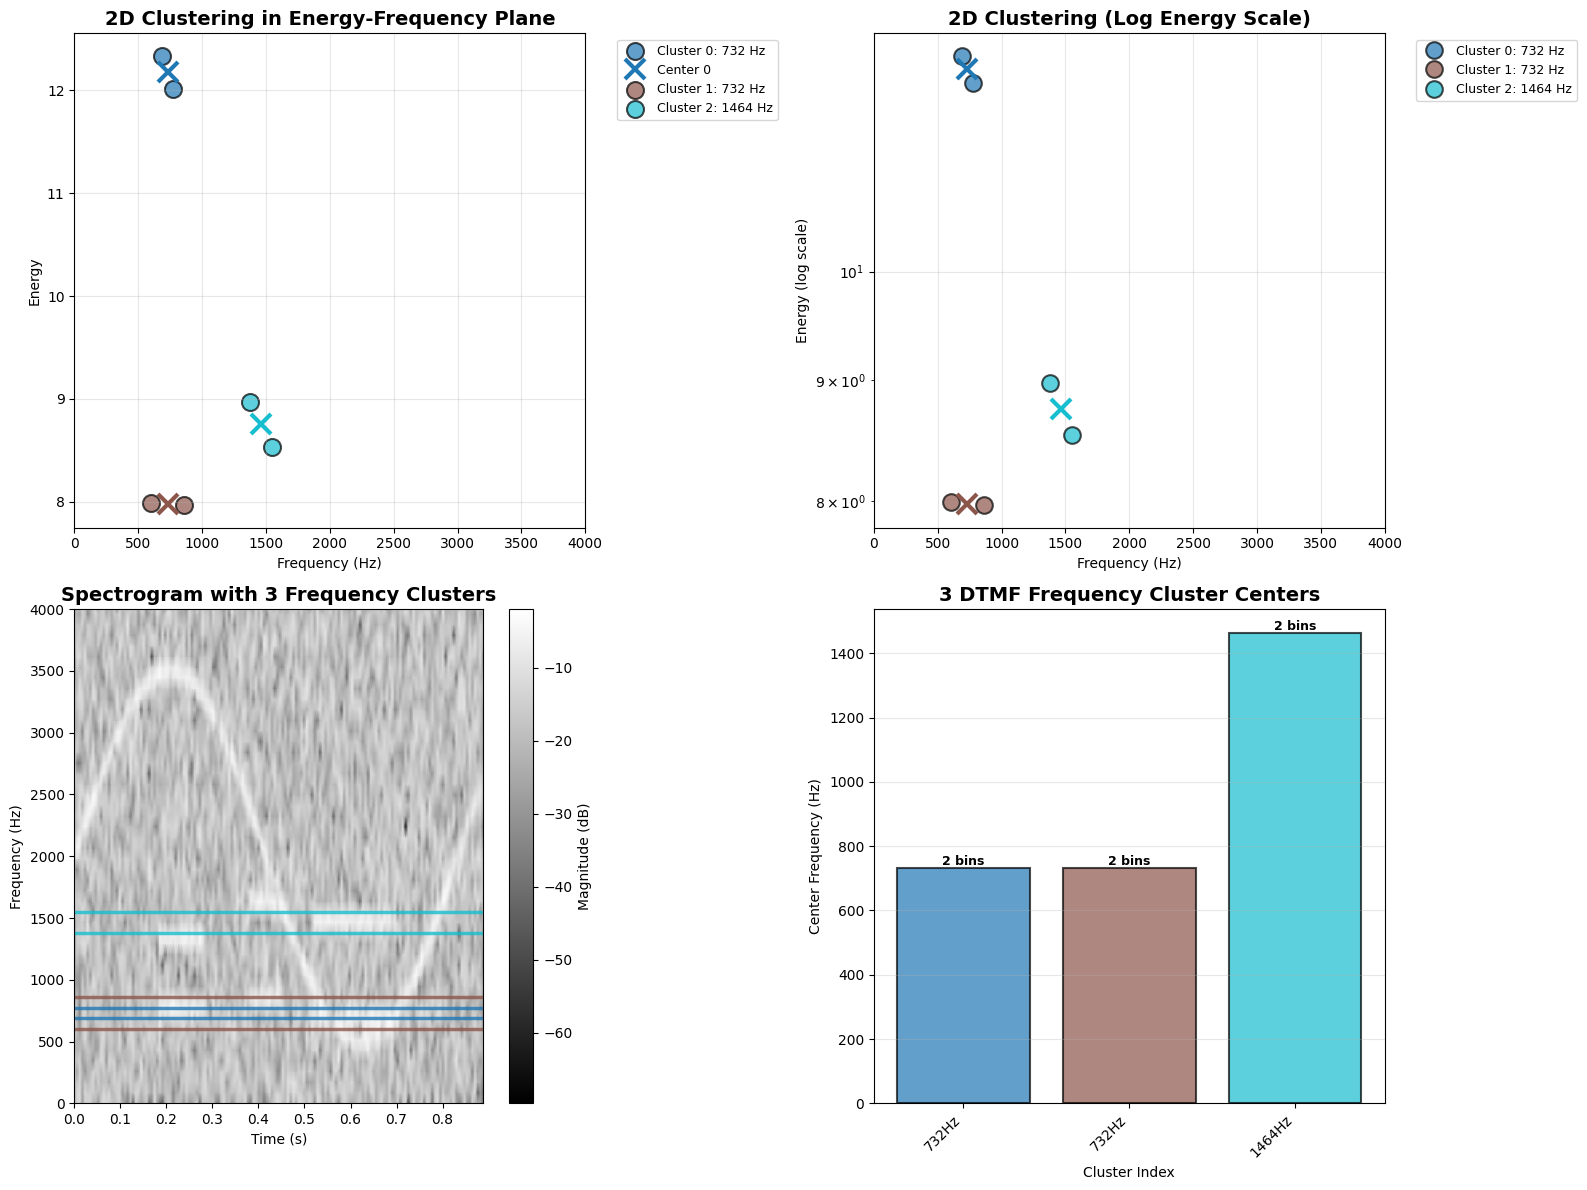

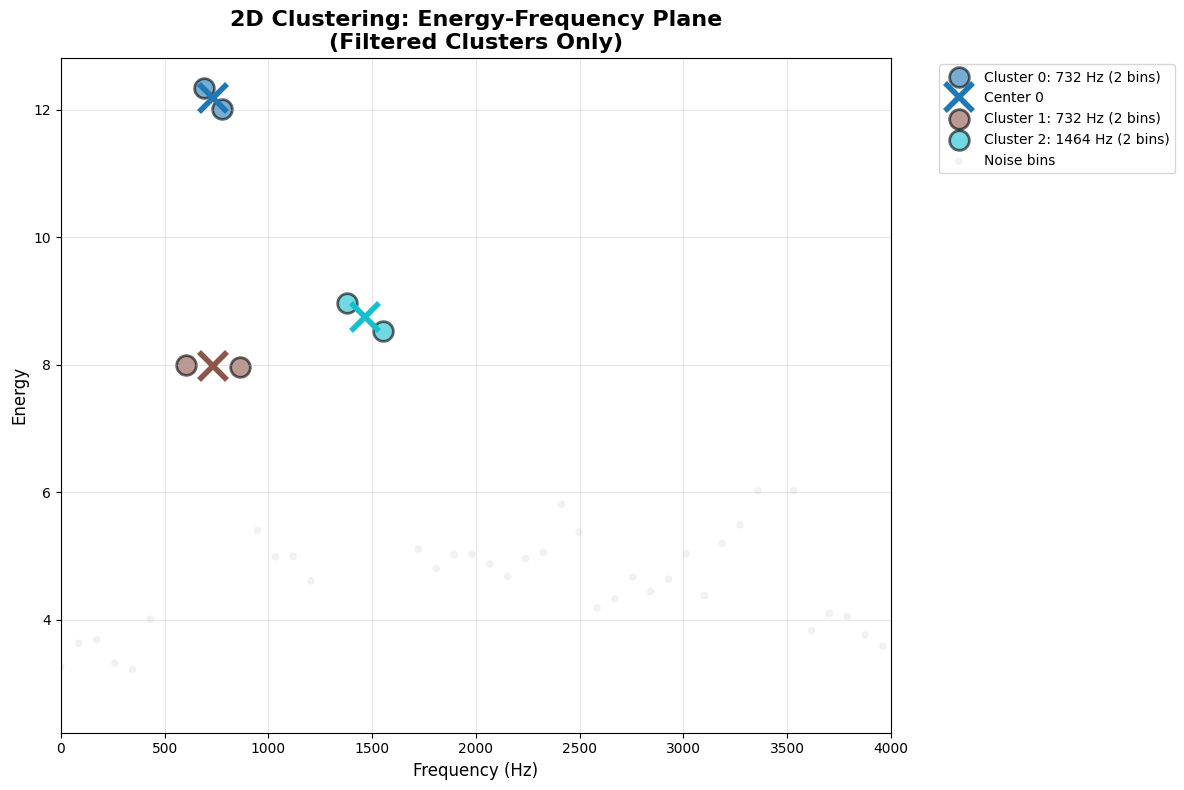

In [ ]:
# Cell 3: Second k-means (k=8) to group frequency bins into DTMF frequency bands
# within the high-energy frequency bins, multiple bins may correspond to the same 
# DTMF frequency due to spectral leakage. we perform 2D k-means clustering 
# on the (frequency, energy) plane to group them into the major DTMF frequency bands

# get frequency and energy values of high-energy bins for 2D clustering
high_energy_freqs = f[high_energy_freq_indices]
high_energy_energies = energy_per_freq[high_energy_freq_indices]

# normalize features for clustering (frequency and energy on different scales)
freq_normalized = (high_energy_freqs - high_energy_freqs.min()) / (high_energy_freqs.max() - high_energy_freqs.min() + 1e-10)
energy_normalized = (high_energy_energies - high_energy_energies.min()) / (high_energy_energies.max() - high_energy_energies.min() + 1e-10)

# 2D feature matrix: (frequency, energy)
features_2d = np.column_stack([freq_normalized, energy_normalized])

# k-means with k=8 to group into DTMF frequency bands (4 low + 4 high)
kmeans_freq = KMeans(n_clusters=8, random_state=0, n_init=10)
freq_cluster_labels = kmeans_freq.fit_predict(features_2d)

# get the 8 major frequency clusters
major_freq_clusters = []
for cluster_id in range(8):
    cluster_mask = freq_cluster_labels == cluster_id
    cluster_freq_indices = high_energy_freq_indices[cluster_mask]
    cluster_freqs = high_energy_freqs[cluster_mask]
    cluster_energies = high_energy_energies[cluster_mask]
    
    # compute cluster center in original space
    cluster_center_freq = np.mean(cluster_freqs)
    cluster_center_energy = np.mean(cluster_energies)
    
    major_freq_clusters.append({
        'cluster_id': cluster_id,
        'center_freq': cluster_center_freq,
        'center_energy': cluster_center_energy,
        'freq_indices': cluster_freq_indices,
        'freqs': cluster_freqs,
        'energies': cluster_energies
    })

# filter out clusters with only 1 frequency bin
major_freq_clusters = [c for c in major_freq_clusters if len(c['freq_indices']) > 1]

# filter out outlier clusters (frequencies outside typical DTMF range: 600-1700 Hz)
# DTMF frequencies: low group ~697, 770, 852, 941 Hz; high group ~1209, 1336, 1477, 1633 Hz
dtmf_freq_range = (500, 1800)  # allow some margin
major_freq_clusters = [c for c in major_freq_clusters 
                      if dtmf_freq_range[0] <= c['center_freq'] <= dtmf_freq_range[1]]

# sort by center frequency
major_freq_clusters.sort(key=lambda x: x['center_freq'])

print(f"Number of major frequency clusters (after filtering): {len(major_freq_clusters)}")
for i, cluster in enumerate(major_freq_clusters):
    print(f"Cluster {i}: center={cluster['center_freq']:.1f} Hz, "
          f"energy={cluster['center_energy']:.2e}, n_bins={len(cluster['freq_indices'])}")

# visualization: 2D clustering in energy-frequency plane
n_clusters = len(major_freq_clusters)
colors_clusters = plt.cm.tab10(np.linspace(0, 1, n_clusters))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# plot 1: 2D clustering in energy-frequency plane (main visualization)
for i, cluster in enumerate(major_freq_clusters):
    axes[0, 0].scatter(cluster['freqs'], cluster['energies'], 
                      c=[colors_clusters[i]], s=150, alpha=0.7, 
                      edgecolors='black', linewidths=1.5,
                      label=f"Cluster {i}: {cluster['center_freq']:.0f} Hz")
    # plot cluster center
    axes[0, 0].plot(cluster['center_freq'], cluster['center_energy'], 
                   'x', color=colors_clusters[i], markersize=15, 
                   markeredgewidth=3, label=f"Center {i}" if i == 0 else "")
axes[0, 0].set_title("2D Clustering in Energy-Frequency Plane", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Frequency (Hz)")
axes[0, 0].set_ylabel("Energy")
axes[0, 0].set_xlim([0, 4000])
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# plot 2: 2D clustering on log scale
for i, cluster in enumerate(major_freq_clusters):
    axes[0, 1].semilogy(cluster['freqs'], cluster['energies'], 
                       'o', color=colors_clusters[i], markersize=12, 
                       alpha=0.7, markeredgecolor='black', markeredgewidth=1.5,
                       label=f"Cluster {i}: {cluster['center_freq']:.0f} Hz")
    axes[0, 1].semilogy(cluster['center_freq'], cluster['center_energy'], 
                       'x', color=colors_clusters[i], markersize=15, 
                       markeredgewidth=3)
axes[0, 1].set_title("2D Clustering (Log Energy Scale)", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Frequency (Hz)")
axes[0, 1].set_ylabel("Energy (log scale)")
axes[0, 1].set_xlim([0, 4000])
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# plot 3: spectrogram with filtered frequency clusters highlighted
spectrogram = np.abs(Zxx)
im = axes[1, 0].pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), 
                           shading='gouraud', cmap='gray')
for i, cluster in enumerate(major_freq_clusters):
    for idx in cluster['freq_indices']:
        axes[1, 0].axhline(y=f[idx], color=colors_clusters[i], 
                          linewidth=2.5, alpha=0.8, 
                          label=f"Cluster {i}" if idx == cluster['freq_indices'][0] else "")
axes[1, 0].set_title(f"Spectrogram with {n_clusters} Frequency Clusters", 
                    fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Time (s)")
axes[1, 0].set_ylabel("Frequency (Hz)")
axes[1, 0].set_ylim([0, 4000])
plt.colorbar(im, ax=axes[1, 0], label="Magnitude (dB)")

# plot 4: cluster centers and bin distribution (bar chart)
if n_clusters > 0:
    cluster_centers_freq = [c['center_freq'] for c in major_freq_clusters]
    cluster_sizes = [len(c['freq_indices']) for c in major_freq_clusters]
    bars = axes[1, 1].bar(range(n_clusters), cluster_centers_freq, 
                         color=colors_clusters[:n_clusters], alpha=0.7, 
                         edgecolor='black', linewidth=1.5)
    axes[1, 1].set_title(f"{n_clusters} DTMF Frequency Cluster Centers", 
                        fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel("Cluster Index")
    axes[1, 1].set_ylabel("Center Frequency (Hz)")
    axes[1, 1].set_xticks(range(n_clusters))
    axes[1, 1].set_xticklabels([f"{c['center_freq']:.0f}Hz" 
                               for c in major_freq_clusters], 
                               rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    # add size labels on bars
    for i, (bar, size) in enumerate(zip(bars, cluster_sizes)):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{size} bins', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# additional visualization: 2D clustering with Voronoi-like regions
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))

# plot all high-energy points colored by cluster
for i, cluster in enumerate(major_freq_clusters):
    ax2.scatter(cluster['freqs'], cluster['energies'], 
               c=[colors_clusters[i]], s=200, alpha=0.6, 
               edgecolors='black', linewidths=2,
               label=f"Cluster {i}: {cluster['center_freq']:.0f} Hz ({len(cluster['freq_indices'])} bins)")
    # plot cluster center
    ax2.plot(cluster['center_freq'], cluster['center_energy'], 
            'x', color=colors_clusters[i], markersize=20, 
            markeredgewidth=4, label=f"Center {i}" if i == 0 else "")

# plot noise bins in gray
noise_freq_indices = np.setdiff1d(np.arange(len(f)), high_energy_freq_indices)
noise_freqs = f[noise_freq_indices]
noise_energies = energy_per_freq[noise_freq_indices]
ax2.scatter(noise_freqs, noise_energies, c='lightgray', s=30, 
           alpha=0.3, label='Noise bins', edgecolors='none')

ax2.set_title("2D Clustering: Energy-Frequency Plane\n(Filtered Clusters Only)", 
             fontsize=16, fontweight='bold')
ax2.set_xlabel("Frequency (Hz)", fontsize=12)
ax2.set_ylabel("Energy", fontsize=12)
ax2.set_xlim([0, 4000])
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Cluster 1 (center=732.1 Hz, 2 freqs):
  Selected freq: 689.1 Hz with 2 CPs
    Freq 689.1 Hz: 2 CPs <-- selected
    Freq 775.2 Hz: 4 CPs
Cluster 3 (center=732.1 Hz, 2 freqs):
  Selected freq: 861.3 Hz with 2 CPs
    Freq 602.9 Hz: 4 CPs
    Freq 861.3 Hz: 2 CPs <-- selected
Cluster 0 (center=1464.3 Hz, 2 freqs):
  Selected freq: 1378.1 Hz with 4 CPs
    Freq 1378.1 Hz: 4 CPs <-- selected
    Freq 1550.4 Hz: 4 CPs

Total unique changepoints across all clusters: 8
Changepoint positions: [4096, 6272, 8448, 9984, 10368, 10624, 11776, 15616]...


/tmp/ipykernel_507368/1611829953.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


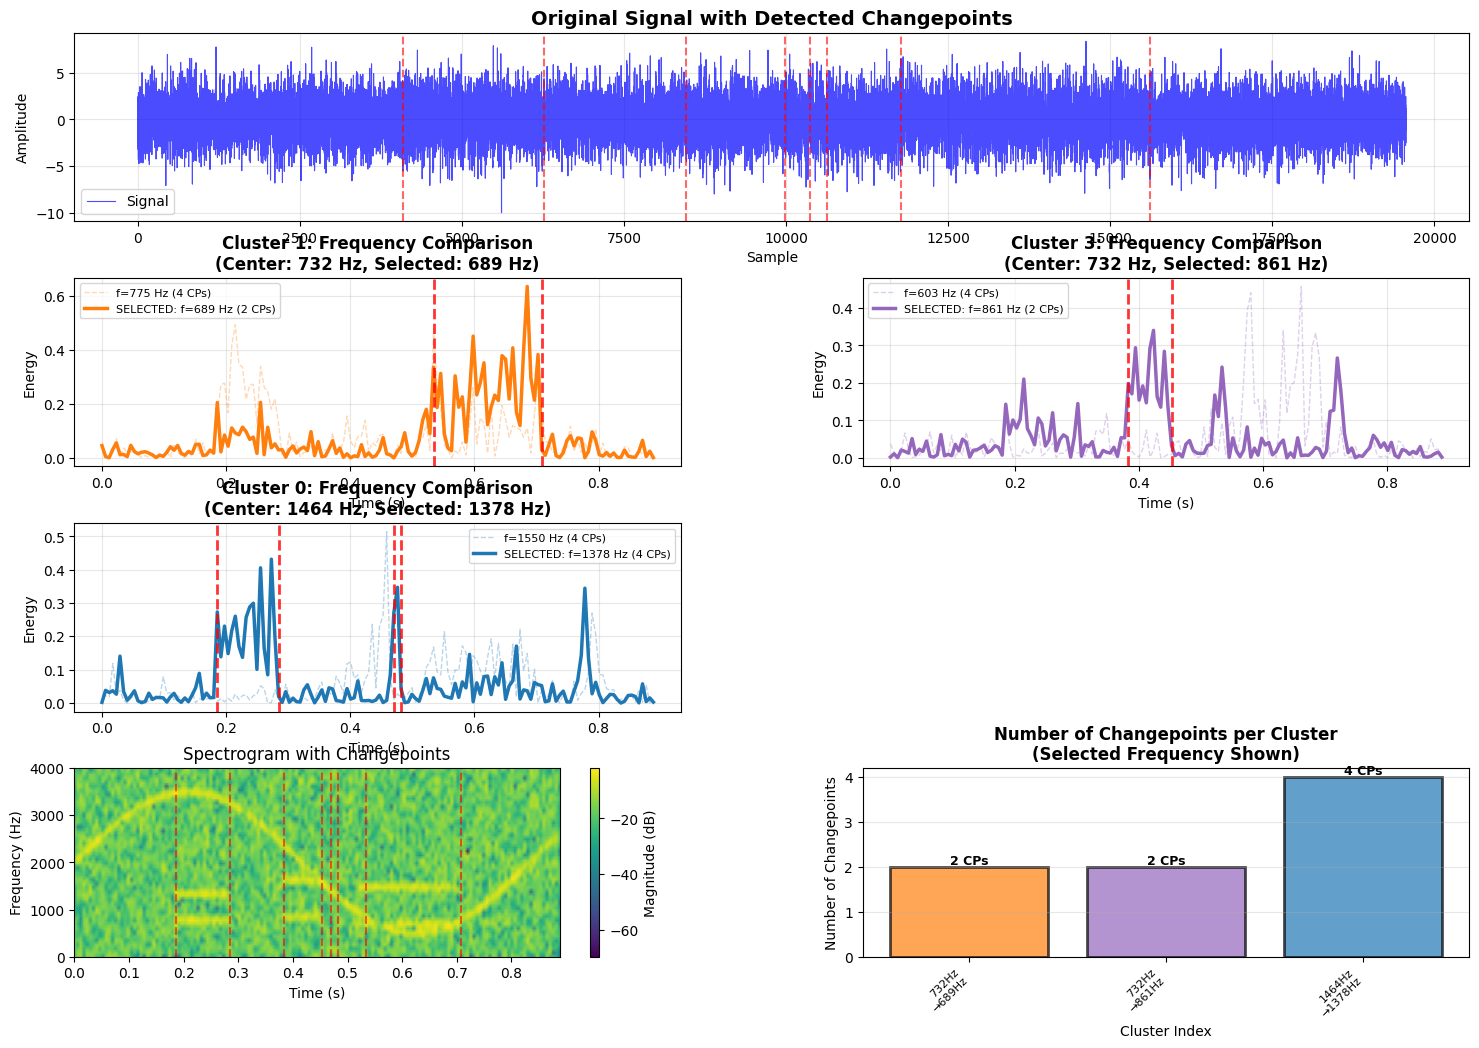

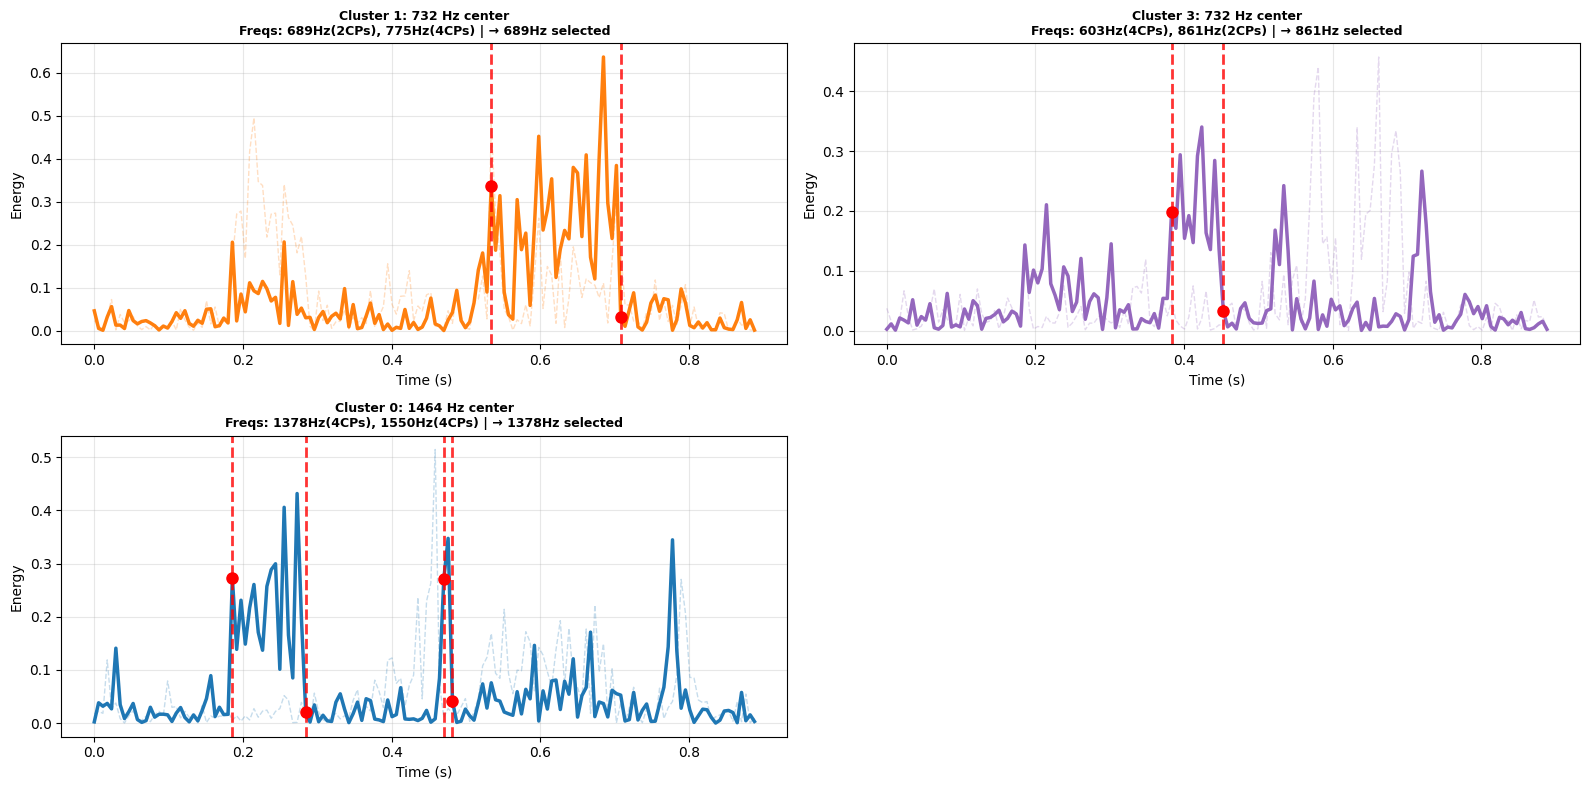

In [ ]:
# Cell 4: Changepoint detection on each frequency cluster
# for each cluster, we perform CP on each frequency bin separately
# since DTMF is dual-tone, we choose the frequency that gives the minimum number of CP points
# (the more stable/clear frequency determines the changepoints)

# compute energy signal for each frequency cluster over time
t_max = len(t)
all_changepoints = []
cluster_energy_signals = []  # store for visualization
frame_step = window_length - overlap

for cluster in major_freq_clusters:
    freq_indices = cluster['freq_indices']
    n_freqs = len(freq_indices)
    
    # perform CP on each frequency bin separately
    freq_cp_results = []
    
    for freq_idx in freq_indices:
        # get energy signal for this single frequency bin
        freq_energy = np.abs(Zxx[freq_idx, :])**2
        
        # apply changepoint detection using PELT
        # BIC penalty: beta = 2 * sigma^2 * log(T)
        sigma_est = np.std(freq_energy)
        pen_bic = 2 * sigma_est**2 * np.log(t_max)
        
        # PELT algorithm
        algo = rpt.Pelt(model="l2", jump=1)
        predicted_bkps = algo.fit_predict(freq_energy, pen=pen_bic)
        
        # convert frame indices to sample indices
        signal_bkps = [min(int(idx * frame_step), len(signal)) 
                       for idx in predicted_bkps[:-1]]
        
        freq_cp_results.append({
            'freq_idx': freq_idx,
            'freq_value': f[freq_idx],
            'changepoints': signal_bkps,
            'frame_bkps': predicted_bkps[:-1],
            'n_cps': len(signal_bkps),
            'energy_signal': freq_energy
        })
    
    # choose the frequency with minimum number of CP points (most stable for dual-tone)
    best_freq_result = min(freq_cp_results, key=lambda x: x['n_cps'])
    
    # also store all frequency results for visualization
    all_freq_results = freq_cp_results.copy()
    
    all_changepoints.append({
        'cluster_id': cluster['cluster_id'],
        'center_freq': cluster['center_freq'],
        'selected_freq': best_freq_result['freq_value'],
        'selected_freq_idx': best_freq_result['freq_idx'],
        'changepoints': best_freq_result['changepoints'],
        'frame_bkps': best_freq_result['frame_bkps'],
        'energy_signal': best_freq_result['energy_signal'],
        'n_cps': best_freq_result['n_cps'],
        'all_freq_results': all_freq_results  # store all for comparison
    })
    
    print(f"Cluster {cluster['cluster_id']} (center={cluster['center_freq']:.1f} Hz, {n_freqs} freqs):")
    print(f"  Selected freq: {best_freq_result['freq_value']:.1f} Hz with {best_freq_result['n_cps']} CPs")
    for fr in freq_cp_results:
        marker = " <-- selected" if fr['freq_idx'] == best_freq_result['freq_idx'] else ""
        print(f"    Freq {fr['freq_value']:.1f} Hz: {fr['n_cps']} CPs{marker}")

# combine changepoints from all clusters
all_bkps = sorted(set([bp for cp_dict in all_changepoints 
                       for bp in cp_dict['changepoints']]))
print(f"\nTotal unique changepoints across all clusters: {len(all_bkps)}")
print(f"Changepoint positions: {all_bkps[:10]}...")  # show first 10

# visualization: changepoint detection results
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# plot 1: original signal with all changepoints
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(signal, 'b-', linewidth=0.8, alpha=0.7, label='Signal')
for bp in all_bkps:
    ax1.axvline(x=bp, color='red', linestyle='--', linewidth=1.5, alpha=0.6)
ax1.set_title("Original Signal with Detected Changepoints", fontsize=14, fontweight='bold')
ax1.set_xlabel("Sample")
ax1.set_ylabel("Amplitude")
ax1.legend()
ax1.grid(True, alpha=0.3)

# plot 2-5: energy signals with changepoints for first 4 clusters
# show all frequencies in each cluster, highlighting the selected one
colors_8 = plt.cm.tab10(np.linspace(0, 1, 8))
for idx in range(min(4, len(all_changepoints))):
    cp_dict = all_changepoints[idx]
    ax = fig.add_subplot(gs[1 + idx//2, idx%2])
    
    # plot all frequencies in this cluster (faded)
    for fr_result in cp_dict['all_freq_results']:
        if fr_result['freq_idx'] != cp_dict['selected_freq_idx']:
            ax.plot(t, fr_result['energy_signal'], 
                   color=colors_8[cp_dict['cluster_id']], linewidth=1, 
                   alpha=0.3, linestyle='--',
                   label=f"f={fr_result['freq_value']:.0f} Hz ({fr_result['n_cps']} CPs)")
    
    # plot selected frequency (bold)
    ax.plot(t, cp_dict['energy_signal'], 
           color=colors_8[cp_dict['cluster_id']], linewidth=2.5, 
           label=f"SELECTED: f={cp_dict['selected_freq']:.0f} Hz ({cp_dict['n_cps']} CPs)")
    
    # plot changepoints for selected frequency
    for frame_bp in cp_dict['frame_bkps']:
        if frame_bp < len(t):
            ax.axvline(x=t[frame_bp], color='red', 
                      linestyle='--', linewidth=2, alpha=0.8)
    
    ax.set_title(f"Cluster {cp_dict['cluster_id']}: Frequency Comparison\n"
                f"(Center: {cp_dict['center_freq']:.0f} Hz, Selected: {cp_dict['selected_freq']:.0f} Hz)",
                fontweight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Energy")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# plot 6: spectrogram with changepoints overlaid
ax6 = fig.add_subplot(gs[3, 0])
spectrogram = np.abs(Zxx)
im = ax6.pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), 
                   shading='gouraud', cmap='viridis')
# overlay changepoints as vertical lines
for cp_dict in all_changepoints:
    for frame_bp in cp_dict['frame_bkps']:
        if frame_bp < len(t):
            ax6.axvline(x=t[frame_bp], color='red', 
                       linestyle='--', linewidth=1.5, alpha=0.6)
ax6.set_title("Spectrogram with Changepoints")
ax6.set_xlabel("Time (s)")
ax6.set_ylabel("Frequency (Hz)")
ax6.set_ylim([0, 4000])
plt.colorbar(im, ax=ax6, label="Magnitude (dB)")

# plot 7: changepoint frequency across clusters with selected frequencies
ax7 = fig.add_subplot(gs[3, 1])
cluster_ids = [cp['cluster_id'] for cp in all_changepoints]
n_changepoints = [cp['n_cps'] for cp in all_changepoints]
selected_freqs = [cp['selected_freq'] for cp in all_changepoints]
bars = ax7.bar(range(len(all_changepoints)), n_changepoints, 
              color=[colors_8[i] for i in cluster_ids], alpha=0.7, edgecolor='black', linewidth=2)
ax7.set_title("Number of Changepoints per Cluster\n(Selected Frequency Shown)", 
             fontweight='bold')
ax7.set_xlabel("Cluster Index")
ax7.set_ylabel("Number of Changepoints")
ax7.set_xticks(range(len(all_changepoints)))
ax7.set_xticklabels([f"{cp['center_freq']:.0f}Hz\n→{cp['selected_freq']:.0f}Hz" 
                    for cp in all_changepoints], 
                    rotation=45, ha='right', fontsize=8)
ax7.grid(True, alpha=0.3, axis='y')
# add value labels on bars
for bar, n_cp, sel_freq in zip(bars, n_changepoints, selected_freqs):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'{n_cp} CPs', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# additional detailed visualization: frequency comparison for all clusters
n_clusters = len(all_changepoints)
n_rows = (n_clusters + 1) // 2
fig2, axes2 = plt.subplots(n_rows, 2, figsize=(16, 4*n_rows))
if n_rows == 1:
    axes2 = axes2.reshape(1, -1)
axes2 = axes2.flatten()

for idx, cp_dict in enumerate(all_changepoints):
    ax = axes2[idx]
    
    # plot all frequencies in this cluster (faded)
    for fr_result in cp_dict['all_freq_results']:
        if fr_result['freq_idx'] != cp_dict['selected_freq_idx']:
            ax.plot(t, fr_result['energy_signal'], 
                   color=colors_8[cp_dict['cluster_id']], linewidth=1, 
                   alpha=0.25, linestyle='--')
    
    # plot selected frequency (bold)
    ax.plot(t, cp_dict['energy_signal'], 
           color=colors_8[cp_dict['cluster_id']], linewidth=2.5)
    
    # mark changepoints for selected frequency
    for frame_bp in cp_dict['frame_bkps']:
        if frame_bp < len(t):
            ax.axvline(x=t[frame_bp], color='red', 
                      linestyle='--', linewidth=2, alpha=0.8)
            ax.plot(t[frame_bp], cp_dict['energy_signal'][frame_bp], 
                   'ro', markersize=8)
    
    # add text annotation showing frequency comparison
    freq_info = ", ".join([f"{fr['freq_value']:.0f}Hz({fr['n_cps']}CPs)" 
                          for fr in cp_dict['all_freq_results']])
    selected_marker = f"→ {cp_dict['selected_freq']:.0f}Hz selected"
    
    ax.set_title(f"Cluster {cp_dict['cluster_id']}: {cp_dict['center_freq']:.0f} Hz center\n"
                f"Freqs: {freq_info} | {selected_marker}", 
                fontsize=9, fontweight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Energy")
    ax.grid(True, alpha=0.3)

# hide unused subplots
for idx in range(n_clusters, len(axes2)):
    axes2[idx].axis('off')

plt.tight_layout()
plt.show()

Low frequency clusters: 2
  689.1 Hz (cluster 1)
  861.3 Hz (cluster 3)

High frequency clusters: 1
  1378.1 Hz (cluster 0)

Total changepoints (ordered): 8
Changepoint times: [4096, 6272, 8448, 9984, 10368, 10624, 11776, 15616]...

=== Detected DTMF Symbols ===
Symbol sequence: ____

Detailed breakdown:


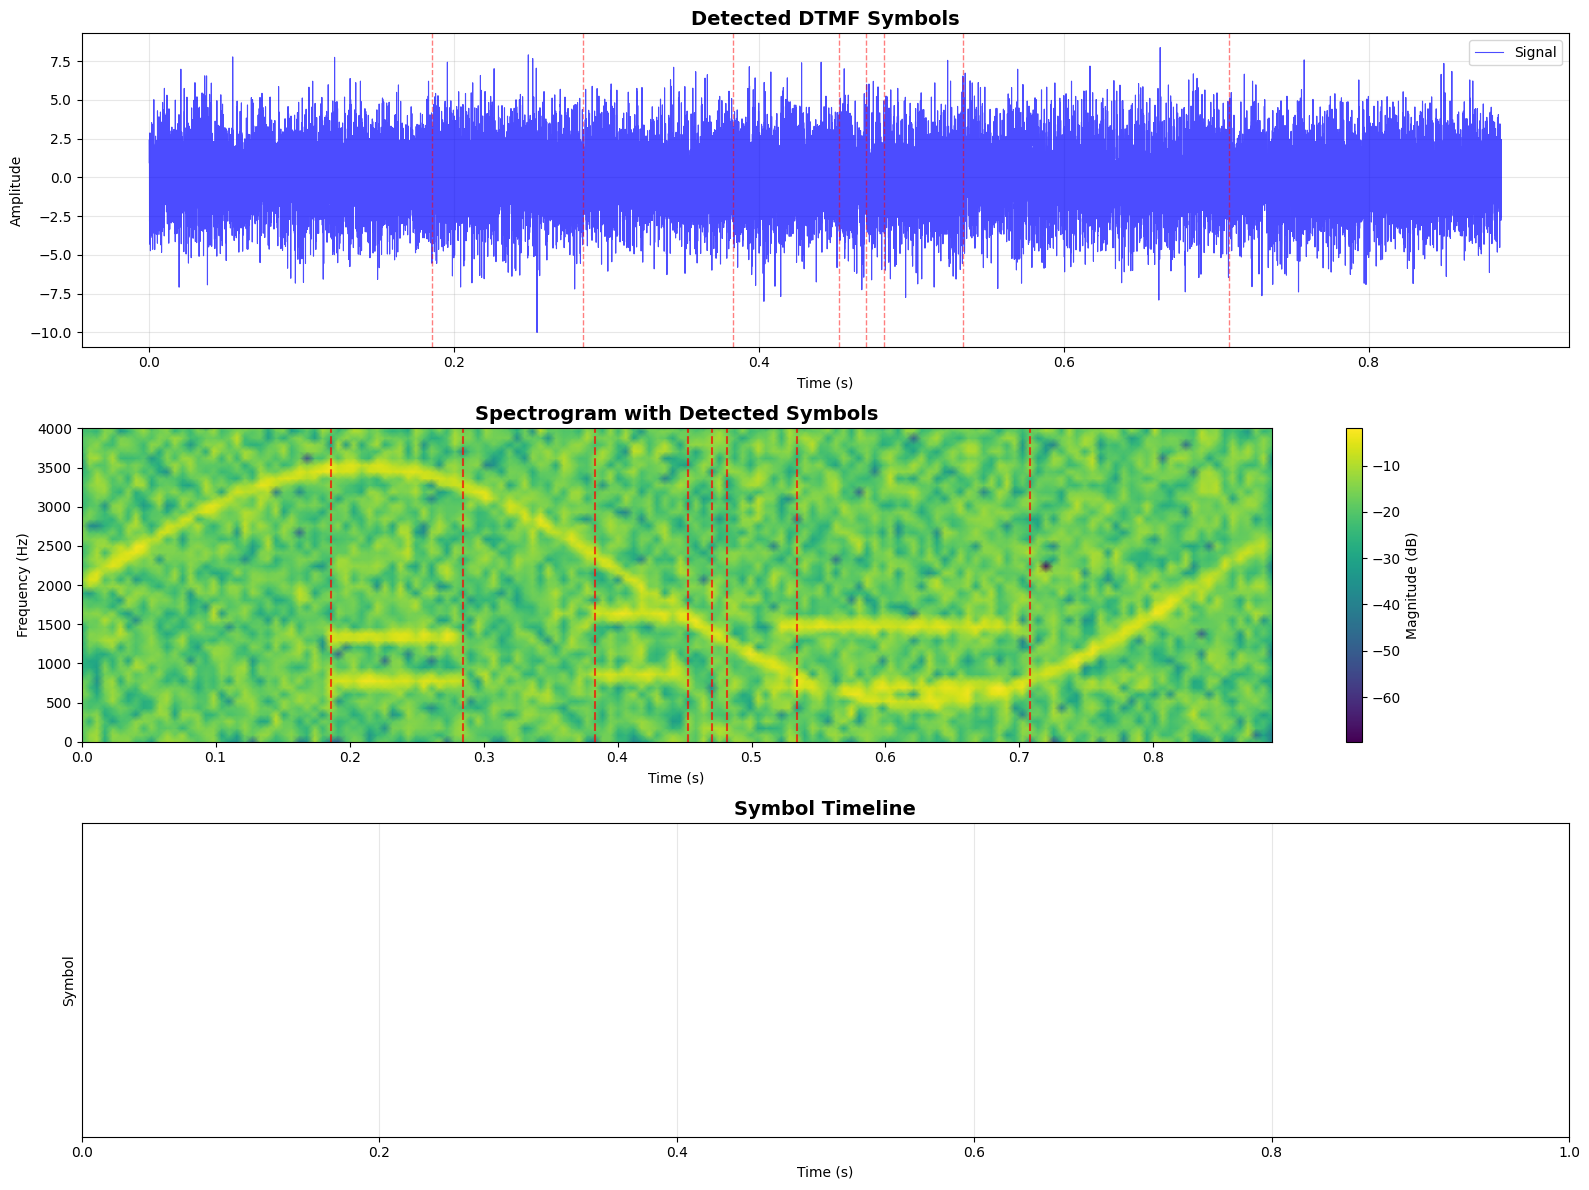


=== Summary ===
Total symbols detected: 0
Symbol sequence: ____
Average symbol duration: nan s


/home/janis/4A/timeseries/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/janis/4A/timeseries/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Cell 5: Order changepoints and assign DTMF symbols
# since DTMF uses dual-tone (low + high frequency), we need to:
# 1. group clusters into low and high frequency groups
# 2. order all changepoints chronologically
# 3. for each time segment, determine which low+high frequency pair is active
# 4. map frequency pairs to DTMF symbols (4x4 = 16 possible symbols)

# DTMF frequency standards
dtmf_low_freqs = [697, 770, 852, 941]  # Hz
dtmf_high_freqs = [1209, 1336, 1477, 1633]  # Hz

# DTMF symbol mapping (row x column)
dtmf_symbols = [
    ['1', '2', '3', 'A'],  # row 0: 697 Hz
    ['4', '5', '6', 'B'],  # row 1: 770 Hz
    ['7', '8', '9', 'C'],  # row 2: 852 Hz
    ['*', '0', '#', 'D']   # row 3: 941 Hz
]

# group clusters into low and high frequency groups
low_freq_clusters = []
high_freq_clusters = []
freq_threshold = 1000  # threshold between low and high groups

for cp_dict in all_changepoints:
    if cp_dict['selected_freq'] < freq_threshold:
        low_freq_clusters.append(cp_dict)
    else:
        high_freq_clusters.append(cp_dict)

print(f"Low frequency clusters: {len(low_freq_clusters)}")
for c in low_freq_clusters:
    print(f"  {c['selected_freq']:.1f} Hz (cluster {c['cluster_id']})")
print(f"\nHigh frequency clusters: {len(high_freq_clusters)}")
for c in high_freq_clusters:
    print(f"  {c['selected_freq']:.1f} Hz (cluster {c['cluster_id']})")

# collect all changepoints and order them chronologically
all_cp_times = []  # store as (time_sample, cluster_id, freq_type)
for cp_dict in all_changepoints:
    freq_type = 'low' if cp_dict['selected_freq'] < freq_threshold else 'high'
    for cp_sample in cp_dict['changepoints']:
        all_cp_times.append((cp_sample, cp_dict['cluster_id'], freq_type, cp_dict['selected_freq']))

# sort by time
all_cp_times.sort(key=lambda x: x[0])

# add start and end boundaries
all_cp_times = [(0, None, 'start', None)] + all_cp_times + [(len(signal), None, 'end', None)]

print(f"\nTotal changepoints (ordered): {len(all_cp_times) - 2}")  # exclude start/end
print(f"Changepoint times: {[cp[0] for cp in all_cp_times[1:min(11, len(all_cp_times)-1)]]}...")

# function to map frequency to DTMF index
def freq_to_dtmf_index(freq, freq_list):
    """find closest DTMF frequency and return its index"""
    distances = [abs(freq - dtmf_f) for dtmf_f in freq_list]
    min_idx = np.argmin(distances)
    min_dist = distances[min_idx]
    # only match if within reasonable tolerance (50 Hz)
    if min_dist < 50:
        return min_idx
    return None

# function to check if a frequency is active in a time segment
def is_freq_active_in_segment(freq_clusters, start_time, end_time, frame_step, energy_threshold_ratio=0.3):
    """check if frequency energy is above threshold in this segment"""
    active_freqs = []
    for cp_dict in freq_clusters:
        # convert sample times to frame indices
        start_frame = max(0, int(start_time / frame_step))
        end_frame = min(len(cp_dict['energy_signal']), int(end_time / frame_step) + 1)
        
        if start_frame >= end_frame:
            continue
            
        # get energy signal for this segment
        segment_energy = cp_dict['energy_signal'][start_frame:end_frame]
        
        if len(segment_energy) == 0:
            continue
        
        # check if average energy is above threshold (relative to max energy of this frequency)
        max_energy = np.max(cp_dict['energy_signal'])
        avg_energy = np.mean(segment_energy)
        
        # frequency is active if average energy is above threshold
        if avg_energy > energy_threshold_ratio * max_energy:
            active_freqs.append({
                'freq': cp_dict['selected_freq'],
                'avg_energy': avg_energy,
                'max_energy': max_energy
            })
    
    # sort by energy (strongest first) and return frequencies
    active_freqs.sort(key=lambda x: x['avg_energy'], reverse=True)
    return [f['freq'] for f in active_freqs]

# detect symbols for each time segment
detected_symbols = []
for i in range(len(all_cp_times) - 1):
    start_time = all_cp_times[i][0]
    end_time = all_cp_times[i+1][0]
    segment_duration = end_time - start_time
    
    # skip very short segments (likely noise)
    if segment_duration < 100:  # minimum duration threshold
        continue
    
    # find active frequencies in this segment (check energy levels)
    active_low_freqs = is_freq_active_in_segment(low_freq_clusters, start_time, end_time, frame_step)
    active_high_freqs = is_freq_active_in_segment(high_freq_clusters, start_time, end_time, frame_step)
    
    # if we have both low and high frequencies, assign symbol
    if len(active_low_freqs) > 0 and len(active_high_freqs) > 0:
        # use the most common or first frequency in each group
        low_freq = active_low_freqs[0]  # take first active
        high_freq = active_high_freqs[0]
        
        # map to DTMF indices
        low_idx = freq_to_dtmf_index(low_freq, dtmf_low_freqs)
        high_idx = freq_to_dtmf_index(high_freq, dtmf_high_freqs)
        
        if low_idx is not None and high_idx is not None:
            symbol = dtmf_symbols[low_idx][high_idx]
            detected_symbols.append({
                'symbol': symbol,
                'start_time': start_time,
                'end_time': end_time,
                'duration': segment_duration,
                'low_freq': low_freq,
                'high_freq': high_freq,
                'low_idx': low_idx,
                'high_idx': high_idx
            })
        else:
            # unmatched frequencies
            detected_symbols.append({
                'symbol': '?',
                'start_time': start_time,
                'end_time': end_time,
                'duration': segment_duration,
                'low_freq': low_freq,
                'high_freq': high_freq,
                'low_idx': None,
                'high_idx': None
            })
    elif len(active_low_freqs) > 0 or len(active_high_freqs) > 0:
        # only one frequency group active (silence or partial)
        detected_symbols.append({
            'symbol': '_',  # silence or partial
            'start_time': start_time,
            'end_time': end_time,
            'duration': segment_duration,
            'low_freq': active_low_freqs[0] if active_low_freqs else None,
            'high_freq': active_high_freqs[0] if active_high_freqs else None,
            'low_idx': None,
            'high_idx': None
        })

# print detected symbols
print(f"\n=== Detected DTMF Symbols ===")
symbol_sequence = ''.join([s['symbol'] for s in detected_symbols])
print(f"Symbol sequence: {symbol_sequence}")
print(f"\nDetailed breakdown:")
for i, sym in enumerate(detected_symbols):
    if sym['symbol'] not in ['_', '?']:
        print(f"  {i+1}. '{sym['symbol']}' at t=[{sym['start_time']/FS:.3f}, {sym['end_time']/FS:.3f}]s "
              f"(duration: {sym['duration']/FS:.3f}s, "
              f"freqs: {sym['low_freq']:.0f}+{sym['high_freq']:.0f} Hz)")

# visualization: detected symbols
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# plot 1: signal with symbol annotations
ax1 = axes[0]
ax1.plot(np.arange(len(signal)) / FS, signal, 'b-', linewidth=0.8, alpha=0.7, label='Signal')
# mark changepoints
for cp_time, _, _, _ in all_cp_times[1:-1]:
    ax1.axvline(x=cp_time/FS, color='red', linestyle='--', linewidth=1, alpha=0.5)
# annotate symbols
y_pos = signal.max() * 0.8
for sym in detected_symbols:
    if sym['symbol'] not in ['_', '?']:
        mid_time = (sym['start_time'] + sym['end_time']) / (2 * FS)
        ax1.text(mid_time, y_pos, sym['symbol'], 
                ha='center', va='bottom', fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        # draw rectangle around symbol region
        ax1.axvspan(sym['start_time']/FS, sym['end_time']/FS, 
                   alpha=0.2, color='yellow')
ax1.set_title("Detected DTMF Symbols", fontsize=14, fontweight='bold')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.legend()
ax1.grid(True, alpha=0.3)

# plot 2: spectrogram with symbol annotations
ax2 = axes[1]
spectrogram = np.abs(Zxx)
im = ax2.pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), 
                   shading='gouraud', cmap='viridis')
# mark changepoints
for cp_time, _, _, _ in all_cp_times[1:-1]:
    ax2.axvline(x=cp_time/FS, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
# annotate symbols
for sym in detected_symbols:
    if sym['symbol'] not in ['_', '?']:
        mid_time = (sym['start_time'] + sym['end_time']) / (2 * FS)
        ax2.text(mid_time, 3500, sym['symbol'], 
                ha='center', va='bottom', fontsize=16, fontweight='bold',
                color='white', bbox=dict(boxstyle='round', facecolor='red', alpha=0.8))
ax2.set_title("Spectrogram with Detected Symbols", fontsize=14, fontweight='bold')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Frequency (Hz)")
ax2.set_ylim([0, 4000])
plt.colorbar(im, ax=ax2, label="Magnitude (dB)")

# plot 3: symbol timeline
ax3 = axes[2]
y_positions = {}
y_counter = 0
for sym in detected_symbols:
    if sym['symbol'] not in ['_', '?']:
        if sym['symbol'] not in y_positions:
            y_positions[sym['symbol']] = y_counter
            y_counter += 1
        y_pos = y_positions[sym['symbol']]
        # draw rectangle for symbol
        width = (sym['end_time'] - sym['start_time']) / FS
        ax3.barh(y_pos, width, left=sym['start_time']/FS, 
                height=0.8, color=plt.cm.tab10(y_pos % 10), 
                edgecolor='black', linewidth=1.5)
        # add symbol label
        mid_time = (sym['start_time'] + sym['end_time']) / (2 * FS)
        ax3.text(mid_time, y_pos, sym['symbol'], 
                ha='center', va='center', fontsize=12, fontweight='bold')
ax3.set_title("Symbol Timeline", fontsize=14, fontweight='bold')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Symbol")
ax3.set_yticks(list(y_positions.values()))
ax3.set_yticklabels(list(y_positions.keys()))
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# summary statistics
print(f"\n=== Summary ===")
print(f"Total symbols detected: {len([s for s in detected_symbols if s['symbol'] not in ['_', '?']])}")
print(f"Symbol sequence: {symbol_sequence}")
if len(detected_symbols) > 0:
    avg_duration = np.mean([s['duration']/FS for s in detected_symbols if s['symbol'] not in ['_', '?']])
    print(f"Average symbol duration: {avg_duration:.3f} s")

Total time periods between changepoints: 7

Distribution statistics:
  Mean: 0.0746 s
  Median: 0.0697 s
  Std: 0.0519 s
  Q25: 0.0348 s, Q75: 0.0987 s, IQR: 0.0639 s

Outlier detection (IQR method):
  Lower bound: -0.0610 s
  Upper bound: 0.1945 s
  Lower outliers: 0
  Upper outliers: 0
  Inliers: 7

Initial total duration: 0.5224 s

After filtering:
  Removed 0 lower outliers
  Remaining periods: 7
  Final total duration: 0.5224 s
  Constraint satisfied: True (threshold: 0.4 s)
  Filtered changepoints: 8 (from 8 original)


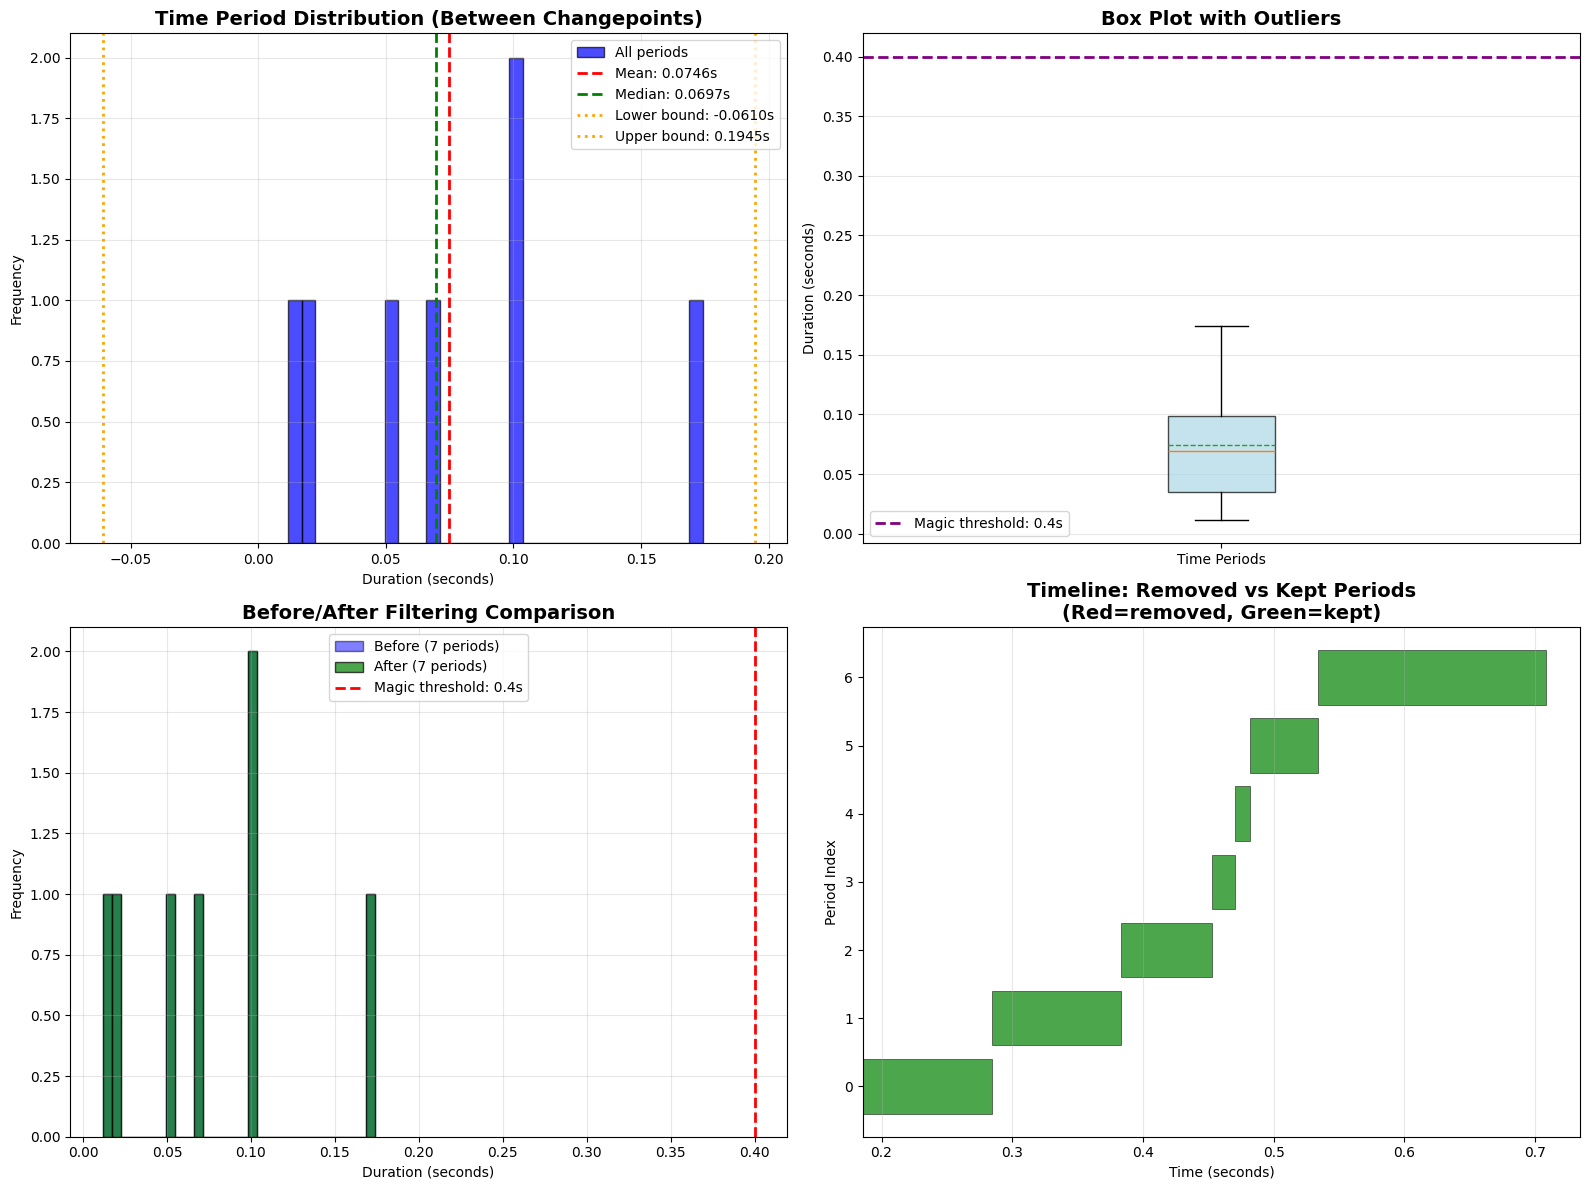


=== Filtering Summary ===
Original periods: 7
Removed lower outliers: 0
Remaining periods: 7
Original total duration: 0.5224 s
Final total duration: 0.5224 s
Removed duration: 0.0000 s


In [ ]:
# Cell 6: Analyze time period distribution and filter outliers
# pattern: CP1 (entry) -> CP2 (out) -> CP1 (entry) -> CP2 (out)...
# we compute time between "out" and next "entry" (gap/silence between symbols)
# remove lower outliers (short gaps) while ensuring sum of remaining periods > 0.4s

# get all changepoints in chronological order (excluding start/end boundaries)
ordered_cps = [cp[0] for cp in all_cp_times[1:-1]]
ordered_cps.sort()

# compute time periods between consecutive changepoints
# these represent: symbol duration, gap duration, symbol duration, gap duration, ...
time_periods = []
for i in range(len(ordered_cps) - 1):
    period_samples = ordered_cps[i+1] - ordered_cps[i]
    period_seconds = period_samples / FS
    time_periods.append({
        'start_cp': ordered_cps[i],
        'end_cp': ordered_cps[i+1],
        'duration_samples': period_samples,
        'duration_seconds': period_seconds,
        'index': i
    })

print(f"Total time periods between changepoints: {len(time_periods)}")

# analyze distribution
period_durations = [p['duration_seconds'] for p in time_periods]
mean_duration = np.mean(period_durations)
median_duration = np.median(period_durations)
std_duration = np.std(period_durations)
q25 = np.percentile(period_durations, 25)
q75 = np.percentile(period_durations, 75)
iqr = q75 - q25

print(f"\nDistribution statistics:")
print(f"  Mean: {mean_duration:.4f} s")
print(f"  Median: {median_duration:.4f} s")
print(f"  Std: {std_duration:.4f} s")
print(f"  Q25: {q25:.4f} s, Q75: {q75:.4f} s, IQR: {iqr:.4f} s")

# identify outliers using IQR method
# lower outlier: < Q25 - 1.5*IQR
# upper outlier: > Q75 + 1.5*IQR
lower_bound = q25 - 1.5 * iqr
upper_bound = q75 + 1.5 * iqr

lower_outliers = [p for p in time_periods if p['duration_seconds'] < lower_bound]
upper_outliers = [p for p in time_periods if p['duration_seconds'] > upper_bound]
inliers = [p for p in time_periods if lower_bound <= p['duration_seconds'] <= upper_bound]

print(f"\nOutlier detection (IQR method):")
print(f"  Lower bound: {lower_bound:.4f} s")
print(f"  Upper bound: {upper_bound:.4f} s")
print(f"  Lower outliers: {len(lower_outliers)}")
print(f"  Upper outliers: {len(upper_outliers)}")
print(f"  Inliers: {len(inliers)}")

# filter lower outliers with constraint: sum of remaining periods > 0.4s
# we want to remove as many lower outliers as possible while maintaining this constraint
magic_threshold = 0.4  # seconds - minimum total duration of remaining periods

# sort lower outliers by duration (shortest first) to remove them in order
lower_outliers_sorted = sorted(lower_outliers, key=lambda x: x['duration_seconds'])

# compute initial sum of all periods
total_duration = sum(p['duration_seconds'] for p in time_periods)
print(f"\nInitial total duration: {total_duration:.4f} s")

# iteratively remove lower outliers, checking constraint
filtered_periods = time_periods.copy()
removed_outliers = []

for outlier in lower_outliers_sorted:
    # check if removing this outlier would violate constraint
    test_duration = sum(p['duration_seconds'] for p in filtered_periods 
                       if p['index'] != outlier['index'])
    
    if test_duration > magic_threshold:
        # safe to remove
        filtered_periods = [p for p in filtered_periods if p['index'] != outlier['index']]
        removed_outliers.append(outlier)
    else:
        # cannot remove without violating constraint
        break

final_duration = sum(p['duration_seconds'] for p in filtered_periods)
print(f"\nAfter filtering:")
print(f"  Removed {len(removed_outliers)} lower outliers")
print(f"  Remaining periods: {len(filtered_periods)}")
print(f"  Final total duration: {final_duration:.4f} s")
print(f"  Constraint satisfied: {final_duration > magic_threshold} (threshold: {magic_threshold} s)")

# get filtered changepoints (only keep CPs that are boundaries of remaining periods)
filtered_cp_indices = set()
for p in filtered_periods:
    filtered_cp_indices.add(p['start_cp'])
    filtered_cp_indices.add(p['end_cp'])

filtered_cps = sorted(list(filtered_cp_indices))
print(f"  Filtered changepoints: {len(filtered_cps)} (from {len(ordered_cps)} original)")

# visualization: distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# plot 1: histogram of time period distribution
ax1 = axes[0, 0]
ax1.hist(period_durations, bins=30, alpha=0.7, color='blue', edgecolor='black', label='All periods')
ax1.axvline(mean_duration, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_duration:.4f}s')
ax1.axvline(median_duration, color='green', linestyle='--', linewidth=2, label=f'Median: {median_duration:.4f}s')
ax1.axvline(lower_bound, color='orange', linestyle=':', linewidth=2, label=f'Lower bound: {lower_bound:.4f}s')
ax1.axvline(upper_bound, color='orange', linestyle=':', linewidth=2, label=f'Upper bound: {upper_bound:.4f}s')
ax1.set_title("Time Period Distribution (Between Changepoints)", fontsize=14, fontweight='bold')
ax1.set_xlabel("Duration (seconds)")
ax1.set_ylabel("Frequency")
ax1.legend()
ax1.grid(True, alpha=0.3)

# plot 2: box plot showing outliers
ax2 = axes[0, 1]
bp = ax2.boxplot(period_durations, vert=True, patch_artist=True, 
                showmeans=True, meanline=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_alpha(0.7)
# highlight outliers
for outlier in lower_outliers:
    ax2.plot(1, outlier['duration_seconds'], 'ro', markersize=8, alpha=0.7, label='Lower outlier' if outlier == lower_outliers[0] else '')
for outlier in upper_outliers:
    ax2.plot(1, outlier['duration_seconds'], 'go', markersize=8, alpha=0.7, label='Upper outlier' if outlier == upper_outliers[0] else '')
ax2.axhline(magic_threshold, color='purple', linestyle='--', linewidth=2, 
           label=f'Magic threshold: {magic_threshold}s')
ax2.set_title("Box Plot with Outliers", fontsize=14, fontweight='bold')
ax2.set_ylabel("Duration (seconds)")
ax2.set_xticklabels(['Time Periods'])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# plot 3: before/after filtering comparison
ax3 = axes[1, 0]
# before filtering
ax3.hist(period_durations, bins=30, alpha=0.5, color='blue', edgecolor='black', 
        label=f'Before ({len(time_periods)} periods)')
# after filtering
filtered_durations = [p['duration_seconds'] for p in filtered_periods]
ax3.hist(filtered_durations, bins=30, alpha=0.7, color='green', edgecolor='black', 
        label=f'After ({len(filtered_periods)} periods)')
ax3.axvline(magic_threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Magic threshold: {magic_threshold}s')
ax3.set_title("Before/After Filtering Comparison", fontsize=14, fontweight='bold')
ax3.set_xlabel("Duration (seconds)")
ax3.set_ylabel("Frequency")
ax3.legend()
ax3.grid(True, alpha=0.3)

# plot 4: timeline showing removed periods
ax4 = axes[1, 1]
# plot all periods
for i, p in enumerate(time_periods):
    color = 'red' if p in removed_outliers else 'green'
    alpha = 0.3 if p in removed_outliers else 0.7
    ax4.barh(i, p['duration_seconds'], left=p['start_cp']/FS, 
            color=color, alpha=alpha, edgecolor='black', linewidth=0.5)
ax4.set_title(f"Timeline: Removed vs Kept Periods\n(Red=removed, Green=kept)", 
             fontsize=14, fontweight='bold')
ax4.set_xlabel("Time (seconds)")
ax4.set_ylabel("Period Index")
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# summary statistics
print(f"\n=== Filtering Summary ===")
print(f"Original periods: {len(time_periods)}")
print(f"Removed lower outliers: {len(removed_outliers)}")
print(f"Remaining periods: {len(filtered_periods)}")
print(f"Original total duration: {total_duration:.4f} s")
print(f"Final total duration: {final_duration:.4f} s")
print(f"Removed duration: {total_duration - final_duration:.4f} s")

Using ground truth symbols for signal 0: ['5', 'C', '3']
=== Period-Symbol Matching ===
Number of ground truth symbols: 3
Ground truth symbols: ['5', 'C', '3']
All filtered periods: 7

Selected 3 biggest periods (by duration):
  1. Duration: 0.1741 s, Time: [0.534, 0.708] s
  2. Duration: 0.0987 s, Time: [0.186, 0.284] s
  3. Duration: 0.0987 s, Time: [0.284, 0.383] s

Selected periods ordered by time:
  1. Time: [0.186, 0.284] s, Duration: 0.0987 s
  2. Time: [0.284, 0.383] s, Duration: 0.0987 s
  3. Time: [0.534, 0.708] s, Duration: 0.1741 s

Symbols (ground truth order):
  1. Symbol: '5'
  2. Symbol: 'C'
  3. Symbol: '3'

Matched 3 period-symbol pairs (by time order):
  Match 1:
    Period: 0.0987 s ([0.186, 0.284] s)
    Assigned symbol: '5' ([0.186, 0.284] s)
    Active freqs: Low=[np.float64(861.328125)], High=[np.float64(1378.125)]
    Low freq details: [(np.float64(861.328125), 3)]
    High freq details: [(np.float64(1378.125), 0)]
    Primary pair: 861 Hz + 1378 Hz
    Verifie

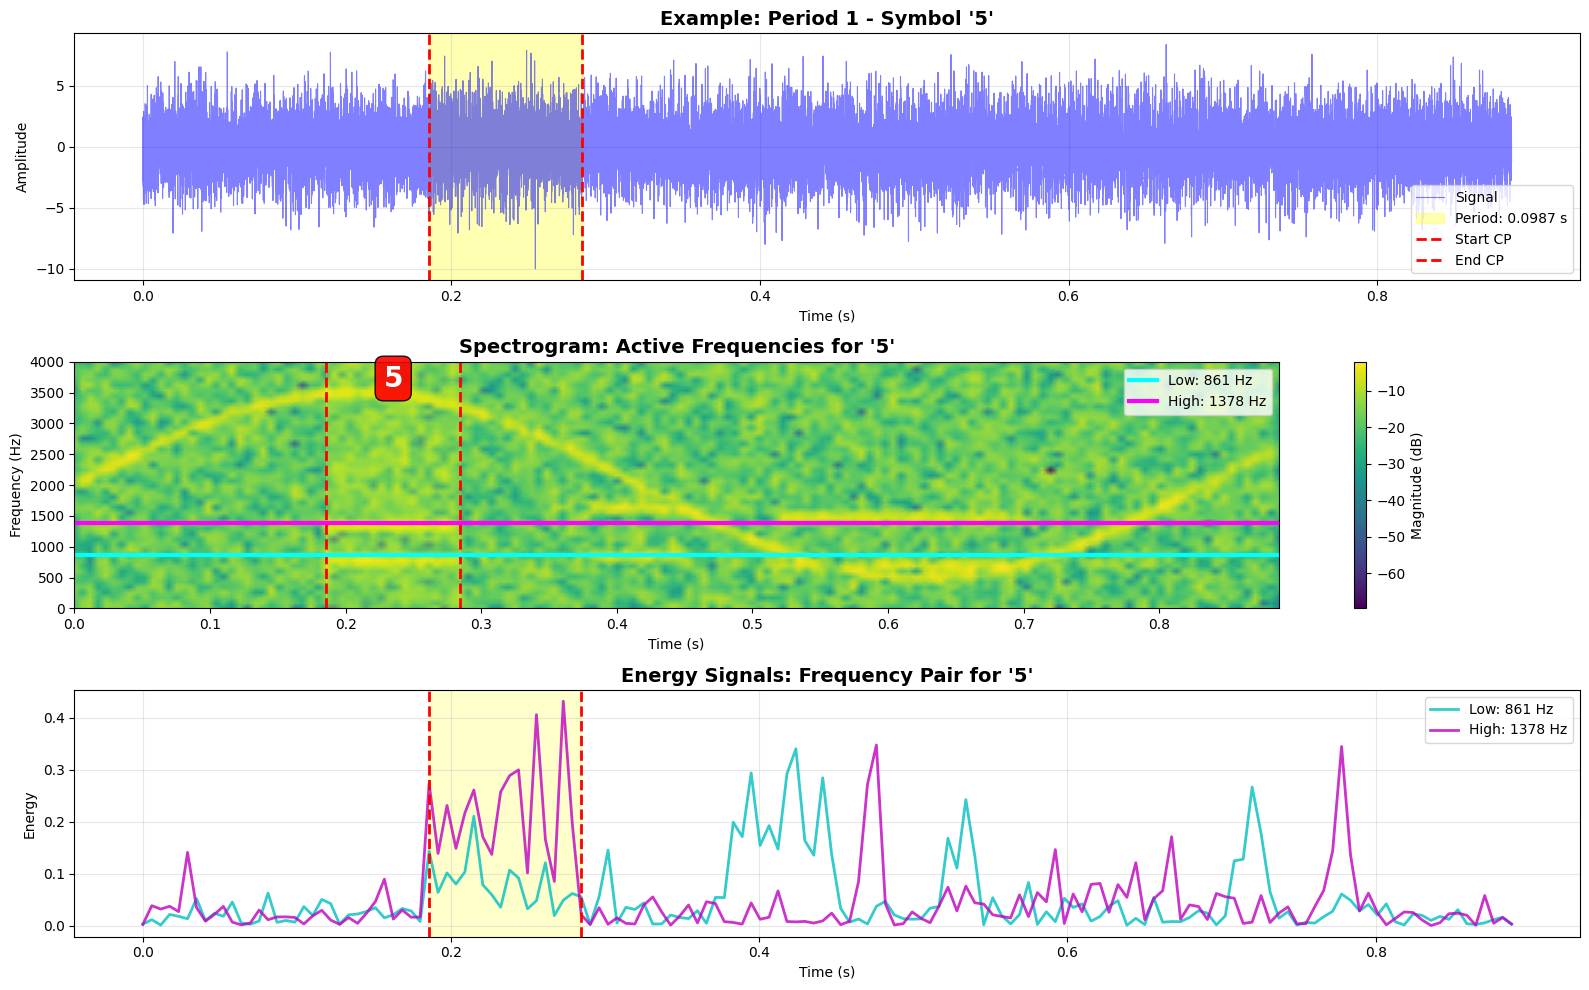


=== All Matches Summary ===
✗ Match 1: '5' (period: 0.0987s, freqs: 861+1378 Hz)
✗ Match 2: 'C' (period: 0.0987s, freqs: 861+1378 Hz)
✗ Match 3: '3' (period: 0.1741s, freqs: 689+1378 Hz)


In [ ]:
# Cell 7: Match periods with symbols and frequency pairs
# use ground truth symbols from y_train[i] for matching
# get the signal index (assuming we're processing signal from X_train[signal_idx])
# NOTE: make sure signal_idx matches the signal variable used above
# if signal = X_train[0], then signal_idx = 0
# if signal = X_train[2], then signal_idx = 2, etc.
signal_idx = 0  # change this to match the signal being processed (signal = X_train[signal_idx])
ground_truth_symbols = y_train[signal_idx]  # get ground truth symbols
print(f"Using ground truth symbols for signal {signal_idx}: {ground_truth_symbols}")

def get_valid_symbols_from_ground_truth(ground_truth_symbols):
    """convert ground truth symbol list to format compatible with matching"""
    # create symbol objects with timing information (we'll match periods to these)
    symbols = []
    for i, sym in enumerate(ground_truth_symbols):
        symbols.append({
            'symbol': sym,
            'index': i,
            'start_time': None,  # will be set by matching
            'end_time': None
        })
    return symbols

def get_valid_symbols(detected_symbols):
    """extract valid symbols (excluding silence and unknown)"""
    return [s for s in detected_symbols if s['symbol'] not in ['_', '?']]

def order_periods_by_duration(periods, descending=True):
    """order time periods by duration"""
    return sorted(periods, key=lambda x: x['duration_seconds'], reverse=descending)

def select_n_biggest_periods(periods, n):
    """select the n biggest periods by duration"""
    ordered_by_duration = sorted(periods, key=lambda x: x['duration_seconds'], reverse=True)
    return ordered_by_duration[:n]

def order_periods_by_time(periods):
    """order periods chronologically by start time"""
    return sorted(periods, key=lambda x: x['start_cp'])

def order_symbols_by_time(symbols):
    """order symbols chronologically by start time"""
    return sorted(symbols, key=lambda x: x['start_time'] if x['start_time'] is not None else 0)

def find_active_frequencies_in_period(period, low_freq_clusters, high_freq_clusters, 
                                     frame_step, energy_threshold_ratio=0.05, cp_tolerance=3000):
    """
    find which low and high frequencies are active during a time period
    since periods are defined by changepoints from different frequency clusters,
    we check which clusters have changepoints that define or are near this period
    uses multiple methods with increasing permissiveness
    """
    start_time = period['start_cp']
    end_time = period['end_cp']
    period_mid = (start_time + end_time) / 2
    period_duration = end_time - start_time
    
    active_low = []
    active_high = []
    
    # method 1: check which clusters have changepoints near the period boundaries
    # if a cluster has changepoints near start_cp or end_cp, it likely defines this period
    for cp_dict in low_freq_clusters:
        cps = sorted(cp_dict['changepoints'])
        # check if any changepoint is near the period boundaries
        near_start = any(abs(cp - start_time) < cp_tolerance for cp in cps)
        near_end = any(abs(cp - end_time) < cp_tolerance for cp in cps)
        # also check if period overlaps with a segment between changepoints
        period_in_segment = False
        for i in range(len(cps) - 1):
            if cps[i] <= period_mid <= cps[i+1]:
                period_in_segment = True
                break
        
        if near_start or near_end or period_in_segment:
            # verify with energy check
            start_frame = max(0, int(start_time / frame_step))
            end_frame = min(len(cp_dict['energy_signal']), int(end_time / frame_step) + 1)
            if start_frame < end_frame:
                segment_energy = cp_dict['energy_signal'][start_frame:end_frame]
                if len(segment_energy) > 0:
                    max_energy = np.max(cp_dict['energy_signal'])
                    avg_energy = np.mean(segment_energy)
                    energy_ratio = avg_energy / max_energy if max_energy > 0 else 0
                    
                    # if changepoints define the period OR energy is above threshold, include it
                    if (near_start or near_end or period_in_segment) or (energy_ratio > energy_threshold_ratio):
                        active_low.append({
                            'freq': cp_dict['selected_freq'],
                            'cluster_id': cp_dict['cluster_id'],
                            'avg_energy': float(avg_energy),
                            'max_energy': float(max_energy),
                            'energy_ratio': float(energy_ratio),
                            'method': 'changepoint' if (near_start or near_end or period_in_segment) else 'energy'
                        })
    
    for cp_dict in high_freq_clusters:
        cps = sorted(cp_dict['changepoints'])
        # check if any changepoint is near the period boundaries
        near_start = any(abs(cp - start_time) < cp_tolerance for cp in cps)
        near_end = any(abs(cp - end_time) < cp_tolerance for cp in cps)
        # also check if period overlaps with a segment between changepoints
        period_in_segment = False
        for i in range(len(cps) - 1):
            if cps[i] <= period_mid <= cps[i+1]:
                period_in_segment = True
                break
        
        if near_start or near_end or period_in_segment:
            # verify with energy check
            start_frame = max(0, int(start_time / frame_step))
            end_frame = min(len(cp_dict['energy_signal']), int(end_time / frame_step) + 1)
            if start_frame < end_frame:
                segment_energy = cp_dict['energy_signal'][start_frame:end_frame]
                if len(segment_energy) > 0:
                    max_energy = np.max(cp_dict['energy_signal'])
                    avg_energy = np.mean(segment_energy)
                    energy_ratio = avg_energy / max_energy if max_energy > 0 else 0
                    
                    # if changepoints define the period OR energy is above threshold, include it
                    if (near_start or near_end or period_in_segment) or (energy_ratio > energy_threshold_ratio):
                        active_high.append({
                            'freq': cp_dict['selected_freq'],
                            'cluster_id': cp_dict['cluster_id'],
                            'avg_energy': float(avg_energy),
                            'max_energy': float(max_energy),
                            'energy_ratio': float(energy_ratio),
                            'method': 'changepoint' if (near_start or near_end or period_in_segment) else 'energy'
                        })
    
    # if still no frequencies found, use pure energy-based method as last resort
    if len(active_low) == 0:
        for cp_dict in low_freq_clusters:
            start_frame = max(0, int(start_time / frame_step))
            end_frame = min(len(cp_dict['energy_signal']), int(end_time / frame_step) + 1)
            if start_frame < end_frame:
                segment_energy = cp_dict['energy_signal'][start_frame:end_frame]
                if len(segment_energy) > 0:
                    max_energy = np.max(cp_dict['energy_signal'])
                    avg_energy = np.mean(segment_energy)
                    energy_ratio = avg_energy / max_energy if max_energy > 0 else 0
                    if energy_ratio > energy_threshold_ratio:
                        active_low.append({
                            'freq': cp_dict['selected_freq'],
                            'cluster_id': cp_dict['cluster_id'],
                            'avg_energy': float(avg_energy),
                            'max_energy': float(max_energy),
                            'energy_ratio': float(energy_ratio),
                            'method': 'energy_fallback'
                        })
    
    if len(active_high) == 0:
        for cp_dict in high_freq_clusters:
            start_frame = max(0, int(start_time / frame_step))
            end_frame = min(len(cp_dict['energy_signal']), int(end_time / frame_step) + 1)
            if start_frame < end_frame:
                segment_energy = cp_dict['energy_signal'][start_frame:end_frame]
                if len(segment_energy) > 0:
                    max_energy = np.max(cp_dict['energy_signal'])
                    avg_energy = np.mean(segment_energy)
                    energy_ratio = avg_energy / max_energy if max_energy > 0 else 0
                    if energy_ratio > energy_threshold_ratio:
                        active_high.append({
                            'freq': cp_dict['selected_freq'],
                            'cluster_id': cp_dict['cluster_id'],
                            'avg_energy': float(avg_energy),
                            'max_energy': float(max_energy),
                            'energy_ratio': float(energy_ratio),
                            'method': 'energy_fallback'
                        })
    
    # final fallback: if still no frequencies, take the one with highest energy in the period
    # this handles edge cases where thresholds are too strict
    if len(active_low) == 0 and len(low_freq_clusters) > 0:
        best_low = None
        best_energy_ratio = 0
        for cp_dict in low_freq_clusters:
            start_frame = max(0, int(start_time / frame_step))
            end_frame = min(len(cp_dict['energy_signal']), int(end_time / frame_step) + 1)
            if start_frame < end_frame:
                segment_energy = cp_dict['energy_signal'][start_frame:end_frame]
                if len(segment_energy) > 0:
                    max_energy = np.max(cp_dict['energy_signal'])
                    avg_energy = np.mean(segment_energy)
                    energy_ratio = avg_energy / max_energy if max_energy > 0 else 0
                    if energy_ratio > best_energy_ratio:
                        best_energy_ratio = energy_ratio
                        best_low = {
                            'freq': cp_dict['selected_freq'],
                            'cluster_id': cp_dict['cluster_id'],
                            'avg_energy': float(avg_energy),
                            'max_energy': float(max_energy),
                            'energy_ratio': float(energy_ratio),
                            'method': 'best_energy_fallback'
                        }
        if best_low is not None:
            active_low.append(best_low)
    
    if len(active_high) == 0 and len(high_freq_clusters) > 0:
        best_high = None
        best_energy_ratio = 0
        for cp_dict in high_freq_clusters:
            start_frame = max(0, int(start_time / frame_step))
            end_frame = min(len(cp_dict['energy_signal']), int(end_time / frame_step) + 1)
            if start_frame < end_frame:
                segment_energy = cp_dict['energy_signal'][start_frame:end_frame]
                if len(segment_energy) > 0:
                    max_energy = np.max(cp_dict['energy_signal'])
                    avg_energy = np.mean(segment_energy)
                    energy_ratio = avg_energy / max_energy if max_energy > 0 else 0
                    if energy_ratio > best_energy_ratio:
                        best_energy_ratio = energy_ratio
                        best_high = {
                            'freq': cp_dict['selected_freq'],
                            'cluster_id': cp_dict['cluster_id'],
                            'avg_energy': float(avg_energy),
                            'max_energy': float(max_energy),
                            'energy_ratio': float(energy_ratio),
                            'method': 'best_energy_fallback'
                        }
        if best_high is not None:
            active_high.append(best_high)
    
    # sort by energy ratio (strongest first), but prioritize changepoint method
    active_low.sort(key=lambda x: (x.get('method') != 'changepoint', -x['energy_ratio']))
    active_high.sort(key=lambda x: (x.get('method') != 'changepoint', -x['energy_ratio']))
    
    return {
        'low_freqs': [f['freq'] for f in active_low],
        'high_freqs': [f['freq'] for f in active_high],
        'low_clusters': active_low,
        'high_clusters': active_high
    }

def match_frequency_pair_to_symbol(low_freq, high_freq, dtmf_low_freqs, dtmf_high_freqs, dtmf_symbols):
    """map a frequency pair to DTMF symbol"""
    def freq_to_dtmf_index(freq, freq_list):
        distances = [abs(freq - dtmf_f) for dtmf_f in freq_list]
        min_idx = np.argmin(distances)
        min_dist = distances[min_idx]
        if min_dist < 50:  # tolerance
            return min_idx
        return None
    
    low_idx = freq_to_dtmf_index(low_freq, dtmf_low_freqs)
    high_idx = freq_to_dtmf_index(high_freq, dtmf_high_freqs)
    
    if low_idx is not None and high_idx is not None:
        return dtmf_symbols[low_idx][high_idx]
    return None

def complete_period_symbol_matching(filtered_periods, ground_truth_symbols, 
                                   low_freq_clusters, high_freq_clusters,
                                   frame_step, dtmf_low_freqs, dtmf_high_freqs, dtmf_symbols):
    """
    complete pipeline: match periods with symbols and frequency pairs
    1. get number of valid symbols from ground truth
    2. select N biggest periods (where N = number of symbols)
    3. order selected periods by time (chronologically)
    4. match: first period (by time) -> first symbol (in order), etc.
    5. for each period, find frequency pair and verify with symbol
    returns list of matched results with period, symbol, and frequency information
    """
    # step 1: get valid symbols from ground truth
    valid_symbols = get_valid_symbols_from_ground_truth(ground_truth_symbols)
    n_symbols = len(valid_symbols)
    print(f"=== Period-Symbol Matching ===")
    print(f"Number of ground truth symbols: {n_symbols}")
    print(f"Ground truth symbols: {ground_truth_symbols}")
    print(f"All filtered periods: {len(filtered_periods)}")
    
    # step 2: select N biggest periods (where N = number of symbols)
    selected_periods = select_n_biggest_periods(filtered_periods, n_symbols)
    print(f"\nSelected {len(selected_periods)} biggest periods (by duration):")
    for i, p in enumerate(selected_periods):
        print(f"  {i+1}. Duration: {p['duration_seconds']:.4f} s, "
              f"Time: [{p['start_cp']/FS:.3f}, {p['end_cp']/FS:.3f}] s")
    
    # step 3: order selected periods by time (chronologically)
    periods_ordered_by_time = order_periods_by_time(selected_periods)
    print(f"\nSelected periods ordered by time:")
    for i, p in enumerate(periods_ordered_by_time):
        print(f"  {i+1}. Time: [{p['start_cp']/FS:.3f}, {p['end_cp']/FS:.3f}] s, "
              f"Duration: {p['duration_seconds']:.4f} s")
    
    # step 4: symbols are already in order (ground truth order)
    # assign time information from periods to symbols
    print(f"\nSymbols (ground truth order):")
    for i, s in enumerate(valid_symbols):
        print(f"  {i+1}. Symbol: '{s['symbol']}'")
    
    # step 5: match periods (by time) with symbols (in ground truth order)
    print(f"\nMatched {len(periods_ordered_by_time)} period-symbol pairs (by time order):")
    
    # step 6: for each match, find active frequencies and verify symbol
    complete_matches = []
    for i, (period, symbol) in enumerate(zip(periods_ordered_by_time, valid_symbols)):
        # find active frequencies in this period
        active_freqs = find_active_frequencies_in_period(
            period, low_freq_clusters, high_freq_clusters, frame_step
        )
        
        # get primary frequency pair (strongest in each group)
        primary_low = active_freqs['low_freqs'][0] if active_freqs['low_freqs'] else None
        primary_high = active_freqs['high_freqs'][0] if active_freqs['high_freqs'] else None
        
        # verify symbol matches frequency pair
        verified_symbol = None
        if primary_low is not None and primary_high is not None:
            verified_symbol = match_frequency_pair_to_symbol(
                primary_low, primary_high, dtmf_low_freqs, dtmf_high_freqs, dtmf_symbols
            )
        
        complete_match = {
            'period': period,
            'assigned_symbol': symbol['symbol'],
            'verified_symbol': verified_symbol,
            'primary_low_freq': primary_low,
            'primary_high_freq': primary_high,
            'all_low_freqs': active_freqs['low_freqs'],
            'all_high_freqs': active_freqs['high_freqs'],
            'match_index': i,
            'symbol_match': (symbol['symbol'] == verified_symbol) if verified_symbol else False
        }
        complete_matches.append(complete_match)
        
        # assign time information to symbol
        symbol['start_time'] = period['start_cp']
        symbol['end_time'] = period['end_cp']
        
        print(f"  Match {i+1}:")
        print(f"    Period: {period['duration_seconds']:.4f} s "
              f"([{period['start_cp']/FS:.3f}, {period['end_cp']/FS:.3f}] s)")
        print(f"    Assigned symbol: '{symbol['symbol']}' "
              f"([{period['start_cp']/FS:.3f}, {period['end_cp']/FS:.3f}] s)")
        print(f"    Active freqs: Low={active_freqs['low_freqs']}, High={active_freqs['high_freqs']}")
        if len(active_freqs['low_clusters']) > 0:
            print(f"    Low freq details: {[(f['freq'], f['cluster_id']) for f in active_freqs['low_clusters']]}")
        if len(active_freqs['high_clusters']) > 0:
            print(f"    High freq details: {[(f['freq'], f['cluster_id']) for f in active_freqs['high_clusters']]}")
        if primary_low and primary_high:
            print(f"    Primary pair: {primary_low:.0f} Hz + {primary_high:.0f} Hz")
            print(f"    Verified symbol: '{verified_symbol}'")
            print(f"    Match: {'✓' if complete_match['symbol_match'] else '✗'}")
        else:
            print(f"    Warning: Missing frequency pair")
            if len(active_freqs['low_freqs']) == 0:
                print(f"      No low frequencies found for this period")
            if len(active_freqs['high_freqs']) == 0:
                print(f"      No high frequencies found for this period")
    
    return complete_matches

# execute the complete matching pipeline using ground truth symbols
complete_matches = complete_period_symbol_matching(
    filtered_periods, ground_truth_symbols,
    low_freq_clusters, high_freq_clusters,
    frame_step, dtmf_low_freqs, dtmf_high_freqs, dtmf_symbols
)

# visualization: show one complete example
if len(complete_matches) > 0:
    example_idx = 0  # show first match as example
    example = complete_matches[example_idx]
    
    print(f"\n=== Complete Example (Match {example_idx+1}) ===")
    print(f"Period duration: {example['period']['duration_seconds']:.4f} s")
    print(f"Time range: [{example['period']['start_cp']/FS:.3f}, {example['period']['end_cp']/FS:.3f}] s")
    print(f"Assigned symbol: '{example['assigned_symbol']}'")
    if example['primary_low_freq'] and example['primary_high_freq']:
        print(f"Primary frequency pair: {example['primary_low_freq']:.0f} Hz + {example['primary_high_freq']:.0f} Hz")
    print(f"Verified symbol: '{example['verified_symbol']}'")
    print(f"All low frequencies: {example['all_low_freqs']}")
    print(f"All high frequencies: {example['all_high_freqs']}")
    print(f"Symbol match: {'✓ CORRECT' if example['symbol_match'] else '✗ MISMATCH'}")
    
    # visualize the example
    fig, axes = plt.subplots(3, 1, figsize=(16, 10))
    
    # plot 1: signal with period highlighted
    ax1 = axes[0]
    ax1.plot(np.arange(len(signal)) / FS, signal, 'b-', linewidth=0.8, alpha=0.5, label='Signal')
    # highlight the period
    period_start = example['period']['start_cp'] / FS
    period_end = example['period']['end_cp'] / FS
    ax1.axvspan(period_start, period_end, alpha=0.3, color='yellow', 
               label=f"Period: {example['period']['duration_seconds']:.4f} s")
    ax1.axvline(period_start, color='red', linestyle='--', linewidth=2, label='Start CP')
    ax1.axvline(period_end, color='red', linestyle='--', linewidth=2, label='End CP')
    ax1.set_title(f"Example: Period {example_idx+1} - Symbol '{example['assigned_symbol']}'", 
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # plot 2: spectrogram with period and frequencies
    ax2 = axes[1]
    spectrogram = np.abs(Zxx)
    im = ax2.pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), 
                       shading='gouraud', cmap='viridis')
    # highlight period
    ax2.axvspan(period_start, period_end, alpha=0.2, color='yellow')
    ax2.axvline(period_start, color='red', linestyle='--', linewidth=2)
    ax2.axvline(period_end, color='red', linestyle='--', linewidth=2)
    # mark active frequencies
    if example['primary_low_freq']:
        ax2.axhline(example['primary_low_freq'], color='cyan', linestyle='-', 
                   linewidth=3, label=f"Low: {example['primary_low_freq']:.0f} Hz")
    if example['primary_high_freq']:
        ax2.axhline(example['primary_high_freq'], color='magenta', linestyle='-', 
                   linewidth=3, label=f"High: {example['primary_high_freq']:.0f} Hz")
    # add symbol annotation
    mid_time = (period_start + period_end) / 2
    ax2.text(mid_time, 3500, example['assigned_symbol'], 
            ha='center', va='bottom', fontsize=20, fontweight='bold',
            color='white', bbox=dict(boxstyle='round', facecolor='red', alpha=0.9))
    ax2.set_title(f"Spectrogram: Active Frequencies for '{example['assigned_symbol']}'", 
                 fontsize=14, fontweight='bold')
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Frequency (Hz)")
    ax2.set_ylim([0, 4000])
    ax2.legend()
    plt.colorbar(im, ax=ax2, label="Magnitude (dB)")
    
    # plot 3: energy signals for active frequencies
    ax3 = axes[2]
    # find energy signals for primary frequencies
    for cp_dict in low_freq_clusters + high_freq_clusters:
        if example['primary_low_freq'] and cp_dict['selected_freq'] == example['primary_low_freq']:
            ax3.plot(t, cp_dict['energy_signal'], 'c-', linewidth=2, 
                    label=f"Low: {example['primary_low_freq']:.0f} Hz", alpha=0.8)
        elif example['primary_high_freq'] and cp_dict['selected_freq'] == example['primary_high_freq']:
            ax3.plot(t, cp_dict['energy_signal'], 'm-', linewidth=2, 
                    label=f"High: {example['primary_high_freq']:.0f} Hz", alpha=0.8)
    # highlight period
    ax3.axvspan(period_start, period_end, alpha=0.2, color='yellow')
    ax3.axvline(period_start, color='red', linestyle='--', linewidth=2)
    ax3.axvline(period_end, color='red', linestyle='--', linewidth=2)
    ax3.set_title(f"Energy Signals: Frequency Pair for '{example['assigned_symbol']}'", 
                 fontsize=14, fontweight='bold')
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Energy")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # summary of all matches
    print(f"\n=== All Matches Summary ===")
    for i, match in enumerate(complete_matches):
        status = "✓" if match['symbol_match'] else "✗"
        if match['primary_low_freq'] and match['primary_high_freq']:
            print(f"{status} Match {i+1}: '{match['assigned_symbol']}' "
                  f"(period: {match['period']['duration_seconds']:.4f}s, "
                  f"freqs: {match['primary_low_freq']:.0f}+{match['primary_high_freq']:.0f} Hz)")
        else:
            print(f"{status} Match {i+1}: '{match['assigned_symbol']}' "
                  f"(period: {match['period']['duration_seconds']:.4f}s, no freq pair)")
else:
    print("\nNo matches found!")

In [ ]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

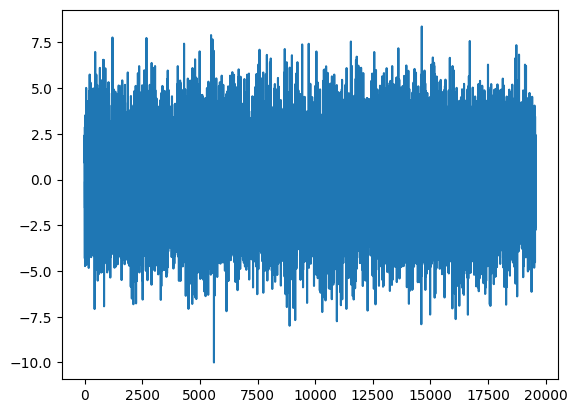

In [ ]:
plt.plot(X_train[0])

In [ ]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))


IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


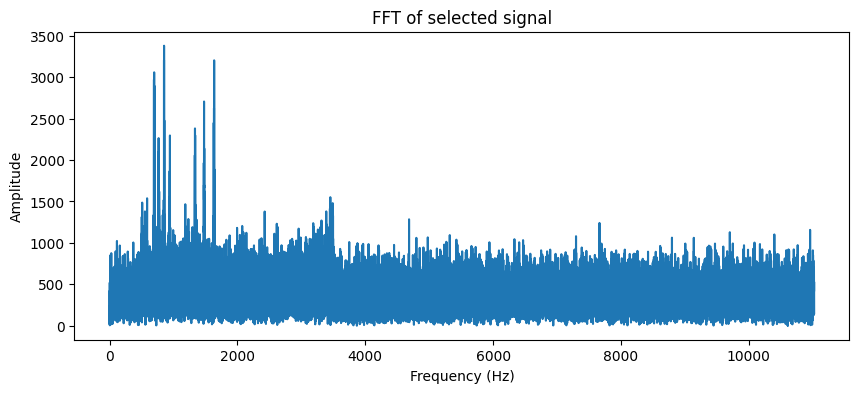

In [ ]:

# Plot FFT of the signal
fft_vals = np.abs(fft(signal))
freqs = np.fft.fftfreq(len(signal), 1/FS)
plt.figure(figsize=(10, 4))
plt.plot(freqs[:len(freqs)//2], fft_vals[:len(fft_vals)//2])
plt.title("FFT of selected signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

# Question 2

# Question 3

# Question 4

## Utility functions: 

In [ ]:
def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r    

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def is_connected(graph) -> bool:
    return graph.is_connected()

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [ ]:
data_df, stations_df, description = load_molene_meteo_dataset()

In [ ]:
data_df["temp"] = data_df['t']- 273.15  # temperature in Celsius
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name         ARZAL  AURAY  BATZ  BEG_MEIL  BELLE ILE-LE TALUT  BIGNAN  \
date                                                                            
2014-01-01 00:00:00    9.7   10.3   NaN       NaN                11.3     7.1   
2014-01-01 01:00:00    9.8   10.4   NaN       NaN                10.3     7.6   
2014-01-01 02:00:00    9.7   10.0   NaN       NaN                11.2     7.7   
2014-01-01 03:00:00    9.4   10.4   NaN       NaN                11.4     7.9   
2014-01-01 04:00:00    9.8   10.8   NaN       NaN                11.4     8.8   

station_name         BREST-GUIPAVAS  BRIGNOGAN  CAMARET  DINARD  ...  \
date                                                             ...   
2014-01-01 00:00:00             9.7        NaN      NaN     6.8  ...   
2014-01-01 01:00:00             9.6        9.2      NaN     6.5  ...   
2014-01-01 02:00:00             9.1        9.4      NaN     6.5  ...   
2014-01-01 03:00:00             9.7       10.1      NaN     7.1  ...   
2014-01-01 04:00:00             9.8       10.2      NaN     7.6  ...   

station_name         SIBIRIL S A  SIZUN  SPEZET  ST BRIEUC  \
date                                                         
2014-01-01 00:00:00          7.4    8.5     8.3        7.5   
2014-01-01 01:00:00          8.2    8.3     8.6        7.0   
2014-01-01 02:00:00          8.5    8.5     8.6        7.5   
2014-01-01 03:00:00          8.5    8.7     8.9        7.2   
2014-01-01 04:00:00          9.1    9.1     9.4        7.6   

station_name         ST NAZAIRE-MONTOIR  ST-SEGAL S A  THEIX  TREGUNC  \
date                                                                    
2014-01-01 00:00:00                 9.0           9.0    9.3     10.8   
2014-01-01 01:00:00                 9.1           9.5    9.1     10.9   
2014-01-01 02:00:00                 9.5           9.4    9.4     10.6   
2014-01-01 03:00:00                 9.0           9.9    8.9     10.8   
2014-01-01 04:00:00                 9.5          10.0    9.6     11.0   

station_name         VANNES-MEUCON  VANNES-SENE  
date                                             
2014-01-01 00:00:00            8.5          9.7  
2014-01-01 01:00:00            8.7          9.9  
2014-01-01 02:00:00            8.8          9.6  
2014-01-01 03:00:00            8.6          9.8  
2014-01-01 04:00:00            9.2         10.2  

[5 rows x 55 columns]

# Question 5

# Question 6

# Question 7

In [ ]:
# Process all signals in the dataset and save results
import json
import os
from io import StringIO
import sys

# create output directory
output_dir = "refs/tps/assignment3/data"
os.makedirs(output_dir, exist_ok=True)

def process_single_signal(signal, ground_truth_symbols, signal_idx, log_file):
    """
    process a single signal through the complete DTMF detection pipeline
    returns all results as dictionaries
    """
    log_file.write(f"\n{'='*80}\n")
    log_file.write(f"Processing Signal {signal_idx}\n")
    log_file.write(f"{'='*80}\n")
    log_file.write(f"Signal length: {len(signal)} samples ({len(signal)/FS:.3f} seconds)\n")
    log_file.write(f"Ground truth symbols: {ground_truth_symbols}\n")
    log_file.flush()
    
    results = {
        'signal_idx': signal_idx,
        'signal_length': len(signal),
        'ground_truth_symbols': ground_truth_symbols,
        'timestamp': dt.datetime.now().isoformat()
    }
    
    try:
        # Cell 1: STFT and energy computation
        log_file.write(f"\n--- Cell 1: STFT and Energy Computation ---\n")
        window_length = 256
        overlap = window_length // 2
        frame_step = window_length - overlap
        
        f, t, Zxx = stft(signal, fs=FS, nperseg=window_length, noverlap=overlap)
        energy_per_freq = np.sum(np.abs(Zxx)**2, axis=1)
        
        log_file.write(f"STFT shape: {Zxx.shape}\n")
        log_file.write(f"Frequency bins: {len(f)}, Time frames: {len(t)}\n")
        log_file.flush()
        
        results['stft'] = {
            'frequencies': f,
            'time_frames': t,
            'spectrogram': Zxx,
            'energy_per_freq': energy_per_freq,
            'window_length': window_length,
            'overlap': overlap,
            'frame_step': frame_step
        }
        
        # Cell 2: First k-means (k=2) to separate signal from noise
        log_file.write(f"\n--- Cell 2: First k-means (k=2) ---\n")
        energy_reshaped = energy_per_freq.reshape(-1, 1)
        kmeans_energy = KMeans(n_clusters=2, random_state=0, n_init=10)
        energy_labels = kmeans_energy.fit_predict(energy_reshaped)
        
        cluster_centers = kmeans_energy.cluster_centers_.flatten()
        signal_cluster_idx = np.argmax(cluster_centers)
        high_energy_freq_indices = np.where(energy_labels == signal_cluster_idx)[0]
        
        log_file.write(f"High-energy (signal) bins: {len(high_energy_freq_indices)}\n")
        log_file.flush()
        
        results['energy_clustering'] = {
            'labels': energy_labels,
            'cluster_centers': cluster_centers,
            'signal_cluster_idx': int(signal_cluster_idx),
            'high_energy_freq_indices': high_energy_freq_indices
        }
        
        # Cell 3: Second k-means (k=8) for frequency clustering
        log_file.write(f"\n--- Cell 3: Second k-means (k=8) ---\n")
        high_energy_freqs = f[high_energy_freq_indices]
        high_energy_energies = energy_per_freq[high_energy_freq_indices]
        
        # adapt k dynamically if we have fewer samples than clusters
        n_high_energy = len(high_energy_freq_indices)
        k_freq = min(8, max(1, n_high_energy))  # at least 1 cluster, at most 8, but not more than samples
        
        if n_high_energy < 2:
            log_file.write(f"Warning: Only {n_high_energy} high-energy frequency bins found, skipping frequency clustering\n")
            major_freq_clusters = []
        else:
            freq_normalized = (high_energy_freqs - high_energy_freqs.min()) / (high_energy_freqs.max() - high_energy_freqs.min() + 1e-10)
            energy_normalized = (high_energy_energies - high_energy_energies.min()) / (high_energy_energies.max() - high_energy_energies.min() + 1e-10)
            features_2d = np.column_stack([freq_normalized, energy_normalized])
            
            kmeans_freq = KMeans(n_clusters=k_freq, random_state=0, n_init=10)
            freq_cluster_labels = kmeans_freq.fit_predict(features_2d)
            
            major_freq_clusters = []
            for cluster_id in range(k_freq):
                cluster_mask = freq_cluster_labels == cluster_id
                cluster_freq_indices = high_energy_freq_indices[cluster_mask]
                cluster_freqs = high_energy_freqs[cluster_mask]
                cluster_energies = high_energy_energies[cluster_mask]
                
                if len(cluster_freq_indices) > 0:  # only add non-empty clusters
                    cluster_center_freq = np.mean(cluster_freqs)
                    cluster_center_energy = np.mean(cluster_energies)
                    
                    major_freq_clusters.append({
                        'cluster_id': cluster_id,
                        'center_freq': cluster_center_freq,
                        'center_energy': cluster_center_energy,
                        'freq_indices': cluster_freq_indices,
                        'freqs': cluster_freqs,
                        'energies': cluster_energies
                    })
        
        # filter clusters
        major_freq_clusters = [c for c in major_freq_clusters if len(c['freq_indices']) > 1]
        dtmf_freq_range = (500, 1800)
        major_freq_clusters = [c for c in major_freq_clusters 
                              if dtmf_freq_range[0] <= c['center_freq'] <= dtmf_freq_range[1]]
        major_freq_clusters.sort(key=lambda x: x['center_freq'])
        
        log_file.write(f"Number of major frequency clusters: {len(major_freq_clusters)}\n")
        for i, cluster in enumerate(major_freq_clusters):
            log_file.write(f"  Cluster {i}: center={cluster['center_freq']:.1f} Hz, "
                          f"n_bins={len(cluster['freq_indices'])}\n")
        log_file.flush()
        
        results['freq_clustering'] = {
            'n_clusters': len(major_freq_clusters),
            'clusters': major_freq_clusters
        }
        
        # Cell 4: Changepoint detection
        log_file.write(f"\n--- Cell 4: Changepoint Detection ---\n")
        t_max = len(t)
        all_changepoints = []
        
        for cluster in major_freq_clusters:
            freq_indices = cluster['freq_indices']
            freq_cp_results = []
            
            for freq_idx in freq_indices:
                freq_energy = np.abs(Zxx[freq_idx, :])**2
                sigma_est = np.std(freq_energy)
                pen_bic = 2 * sigma_est**2 * np.log(t_max)
                
                algo = rpt.Pelt(model="l2", jump=1)
                predicted_bkps = algo.fit_predict(freq_energy, pen=pen_bic)
                signal_bkps = [min(int(idx * frame_step), len(signal)) 
                              for idx in predicted_bkps[:-1]]
                
                freq_cp_results.append({
                    'freq_idx': freq_idx,
                    'freq_value': f[freq_idx],
                    'changepoints': signal_bkps,
                    'frame_bkps': predicted_bkps[:-1],
                    'n_cps': len(signal_bkps),
                    'energy_signal': freq_energy
                })
            
            best_freq_result = min(freq_cp_results, key=lambda x: x['n_cps'])
            
            all_changepoints.append({
                'cluster_id': cluster['cluster_id'],
                'center_freq': cluster['center_freq'],
                'selected_freq': best_freq_result['freq_value'],
                'selected_freq_idx': best_freq_result['freq_idx'],
                'changepoints': best_freq_result['changepoints'],
                'frame_bkps': best_freq_result['frame_bkps'],
                'energy_signal': best_freq_result['energy_signal'],
                'n_cps': best_freq_result['n_cps']
            })
            
            log_file.write(f"Cluster {cluster['cluster_id']}: selected freq {best_freq_result['freq_value']:.1f} Hz "
                          f"with {best_freq_result['n_cps']} CPs\n")
        
        log_file.flush()
        
        results['changepoints'] = all_changepoints
        
        # group into low and high frequency clusters
        dtmf_low_freqs = [697, 770, 852, 941]
        dtmf_high_freqs = [1209, 1336, 1477, 1633]
        freq_threshold = 1000
        
        low_freq_clusters = [c for c in all_changepoints if c['selected_freq'] < freq_threshold]
        high_freq_clusters = [c for c in all_changepoints if c['selected_freq'] >= freq_threshold]
        
        log_file.write(f"\nLow frequency clusters: {len(low_freq_clusters)}\n")
        log_file.write(f"High frequency clusters: {len(high_freq_clusters)}\n")
        log_file.flush()
        
        # Cell 6: Distribution analysis and filtering
        log_file.write(f"\n--- Cell 6: Distribution Analysis ---\n")
        all_cp_times_list = []
        for cp_dict in all_changepoints:
            for cp_sample in cp_dict['changepoints']:
                all_cp_times_list.append(cp_sample)
        
        ordered_cps = sorted(set(all_cp_times_list))
        time_periods = []
        for i in range(len(ordered_cps) - 1):
            period_samples = ordered_cps[i+1] - ordered_cps[i]
            period_seconds = period_samples / FS
            time_periods.append({
                'start_cp': ordered_cps[i],
                'end_cp': ordered_cps[i+1],
                'duration_samples': period_samples,
                'duration_seconds': period_seconds,
                'index': i
            })
        
        period_durations = [p['duration_seconds'] for p in time_periods]
        q25 = np.percentile(period_durations, 25)
        q75 = np.percentile(period_durations, 75)
        iqr = q75 - q25
        lower_bound = q25 - 1.5 * iqr
        
        lower_outliers = [p for p in time_periods if p['duration_seconds'] < lower_bound]
        lower_outliers_sorted = sorted(lower_outliers, key=lambda x: x['duration_seconds'])
        
        magic_threshold = 0.4
        filtered_periods = time_periods.copy()
        removed_outliers = []
        
        for outlier in lower_outliers_sorted:
            test_duration = sum(p['duration_seconds'] for p in filtered_periods 
                               if p['index'] != outlier['index'])
            if test_duration > magic_threshold:
                filtered_periods = [p for p in filtered_periods if p['index'] != outlier['index']]
                removed_outliers.append(outlier)
            else:
                break
        
        log_file.write(f"Original periods: {len(time_periods)}\n")
        log_file.write(f"Removed outliers: {len(removed_outliers)}\n")
        log_file.write(f"Filtered periods: {len(filtered_periods)}\n")
        log_file.flush()
        
        results['period_analysis'] = {
            'time_periods': time_periods,
            'filtered_periods': filtered_periods,
            'removed_outliers': removed_outliers,
            'statistics': {
                'q25': float(q25),
                'q75': float(q75),
                'iqr': float(iqr),
                'lower_bound': float(lower_bound)
            }
        }
        
        # Cell 7: Period-symbol matching
        log_file.write(f"\n--- Cell 7: Period-Symbol Matching ---\n")
        n_symbols = len(ground_truth_symbols)
        
        # select N biggest periods
        selected_periods = sorted(filtered_periods, key=lambda x: x['duration_seconds'], reverse=True)[:n_symbols]
        periods_ordered_by_time = sorted(selected_periods, key=lambda x: x['start_cp'])
        
        log_file.write(f"Selected {len(selected_periods)} periods for {n_symbols} symbols\n")
        
        # use the matching functions (simplified version)
        complete_matches = []
        for i, (period, symbol) in enumerate(zip(periods_ordered_by_time, ground_truth_symbols)):
            # find active frequencies using the improved function
            active_freqs = find_active_frequencies_in_period(
                period, low_freq_clusters, high_freq_clusters, frame_step,
                energy_threshold_ratio=0.05, cp_tolerance=3000
            )
            active_low = active_freqs['low_clusters']
            active_high = active_freqs['high_clusters']
            
            primary_low = active_freqs['low_freqs'][0] if active_freqs['low_freqs'] else None
            primary_high = active_freqs['high_freqs'][0] if active_freqs['high_freqs'] else None
            
            # verify symbol
            verified_symbol = None
            if primary_low and primary_high:
                def freq_to_dtmf_index(freq, freq_list):
                    distances = [abs(freq - dtmf_f) for dtmf_f in freq_list]
                    min_idx = np.argmin(distances)
                    min_dist = distances[min_idx]
                    return min_idx if min_dist < 50 else None
                
                dtmf_symbols = [
                    ['1', '2', '3', 'A'],
                    ['4', '5', '6', 'B'],
                    ['7', '8', '9', 'C'],
                    ['*', '0', '#', 'D']
                ]
                
                low_idx = freq_to_dtmf_index(primary_low, dtmf_low_freqs)
                high_idx = freq_to_dtmf_index(primary_high, dtmf_high_freqs)
                if low_idx is not None and high_idx is not None:
                    verified_symbol = dtmf_symbols[low_idx][high_idx]
            
            match = {
                'period': period,
                'assigned_symbol': symbol,
                'verified_symbol': verified_symbol,
                'primary_low_freq': primary_low,
                'primary_high_freq': primary_high,
                'active_low_freqs': [f['freq'] for f in active_low],
                'active_high_freqs': [f['freq'] for f in active_high],
                'match_index': i,
                'symbol_match': (symbol == verified_symbol) if verified_symbol else False
            }
            complete_matches.append(match)
            
            # format frequencies safely (handle None values)
            low_freq_str = f"{primary_low:.0f}" if primary_low is not None else "None"
            high_freq_str = f"{primary_high:.0f}" if primary_high is not None else "None"
            freq_pair_str = f"{low_freq_str}+{high_freq_str}Hz" if (primary_low is not None and primary_high is not None) else "no freq pair"
            
            log_file.write(f"Match {i+1}: '{symbol}' -> period [{period['start_cp']/FS:.3f}, {period['end_cp']/FS:.3f}]s, "
                          f"freqs: {freq_pair_str}, verified: '{verified_symbol}', "
                          f"match: {'✓' if match['symbol_match'] else '✗'}\n")
        
        log_file.flush()
        
        results['matches'] = complete_matches
        results['success'] = True
        
    except Exception as e:
        log_file.write(f"\nERROR processing signal {signal_idx}: {str(e)}\n")
        import traceback
        log_file.write(traceback.format_exc())
        results['success'] = False
        results['error'] = str(e)
        log_file.flush()
    
    return results

# process all signals
print(f"Processing {len(X_train)} signals...")
print(f"Results will be saved to: {output_dir}")

for i in range(len(X_train)):
    signal = X_train[i]
    ground_truth = y_train[i]
    
    # create log file
    log_path = os.path.join(output_dir, f"log_{i}.txt")
    with open(log_path, 'w') as log_file:
        log_file.write(f"DTMF Detection Log for Signal {i}\n")
        log_file.write(f"Timestamp: {dt.datetime.now().isoformat()}\n")
        
        # process signal
        results = process_single_signal(signal, ground_truth, i, log_file)
        
        # save NPZ file
        npz_path = os.path.join(output_dir, f"results_{i}.npz")
        
        # prepare data for NPZ (convert to numpy arrays where possible)
        npz_data = {
            'signal': signal,
            'signal_idx': np.array([i]),
            'ground_truth_symbols': np.array(ground_truth, dtype=object),
            'success': np.array([results.get('success', False)])
        }
        
        if 'stft' in results:
            npz_data['stft_frequencies'] = results['stft']['frequencies']
            npz_data['stft_time_frames'] = results['stft']['time_frames']
            npz_data['stft_spectrogram'] = results['stft']['spectrogram']
            npz_data['energy_per_freq'] = results['stft']['energy_per_freq']
        
        if 'changepoints' in results:
            # save changepoints as separate arrays for each cluster
            for j, cp in enumerate(results['changepoints']):
                npz_data[f'changepoints_cluster_{j}'] = np.array(cp['changepoints'])
                npz_data[f'changepoint_freq_cluster_{j}'] = np.array([cp['selected_freq']])
        
        if 'period_analysis' in results and 'filtered_periods' in results['period_analysis']:
            filtered_periods = results['period_analysis']['filtered_periods']
            npz_data['filtered_periods_starts'] = np.array([p['start_cp'] for p in filtered_periods])
            npz_data['filtered_periods_ends'] = np.array([p['end_cp'] for p in filtered_periods])
            npz_data['filtered_periods_durations'] = np.array([p['duration_seconds'] for p in filtered_periods])
        
        if 'matches' in results:
            matches = results['matches']
            npz_data['matches_assigned_symbols'] = np.array([m['assigned_symbol'] for m in matches], dtype=object)
            npz_data['matches_verified_symbols'] = np.array([m.get('verified_symbol', '') or '' for m in matches], dtype=object)
            npz_data['matches_low_freqs'] = np.array([m.get('primary_low_freq', 0.0) or 0.0 for m in matches])
            npz_data['matches_high_freqs'] = np.array([m.get('primary_high_freq', 0.0) or 0.0 for m in matches])
            npz_data['matches_period_starts'] = np.array([m['period']['start_cp'] for m in matches])
            npz_data['matches_period_ends'] = np.array([m['period']['end_cp'] for m in matches])
            npz_data['matches_symbol_match'] = np.array([m['symbol_match'] for m in matches])
        
        np.savez_compressed(npz_path, **npz_data)
        
        # save JSON file
        json_path = os.path.join(output_dir, f"results_{i}.json")
        json_results = {
            'signal_idx': results['signal_idx'],
            'signal_length': results['signal_length'],
            'ground_truth_symbols': results['ground_truth_symbols'],
            'timestamp': results['timestamp'],
            'success': results.get('success', False),
            'stft_params': {
                'window_length': results.get('stft', {}).get('window_length', 256),
                'overlap': results.get('stft', {}).get('overlap', 128),
                'frame_step': results.get('stft', {}).get('frame_step', 128)
            },
            'freq_clustering': {
                'n_clusters': results.get('freq_clustering', {}).get('n_clusters', 0),
                'cluster_centers': [c['center_freq'] for c in results.get('freq_clustering', {}).get('clusters', [])]
            },
            'changepoints_summary': [
                {
                    'cluster_id': cp['cluster_id'],
                    'selected_freq': float(cp['selected_freq']),
                    'n_changepoints': cp['n_cps'],
                    'changepoints': [int(x) for x in cp['changepoints']]
                }
                for cp in results.get('changepoints', [])
            ],
            'period_analysis': {
                'n_original_periods': len(results.get('period_analysis', {}).get('time_periods', [])),
                'n_filtered_periods': len(results.get('period_analysis', {}).get('filtered_periods', [])),
                'n_removed_outliers': len(results.get('period_analysis', {}).get('removed_outliers', [])),
                'statistics': results.get('period_analysis', {}).get('statistics', {})
            },
            'matches': [
                {
                    'match_index': m['match_index'],
                    'assigned_symbol': m['assigned_symbol'],
                    'verified_symbol': m.get('verified_symbol'),
                    'primary_low_freq': float(m.get('primary_low_freq', 0)) if m.get('primary_low_freq') else None,
                    'primary_high_freq': float(m.get('primary_high_freq', 0)) if m.get('primary_high_freq') else None,
                    'period_start': float(m['period']['start_cp'] / FS),
                    'period_end': float(m['period']['end_cp'] / FS),
                    'period_duration': float(m['period']['duration_seconds']),
                    'symbol_match': m['symbol_match']
                }
                for m in results.get('matches', [])
            ]
        }
        
        if 'error' in results:
            json_results['error'] = results['error']
        
        with open(json_path, 'w') as f:
            json.dump(json_results, f, indent=2)
        
        log_file.write(f"\n{'='*80}\n")
        log_file.write(f"Results saved to:\n")
        log_file.write(f"  NPZ: {npz_path}\n")
        log_file.write(f"  JSON: {json_path}\n")
        log_file.write(f"  Log: {log_path}\n")
        log_file.write(f"{'='*80}\n")
    
    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{len(X_train)} signals...")

print(f"\nCompleted! All results saved to {output_dir}")

# create summary statistics
print("\nGenerating summary statistics...")
summary = {
    'total_signals': len(X_train),
    'timestamp': dt.datetime.now().isoformat(),
    'signals_processed': [],
    'overall_statistics': {
        'total_matches': 0,
        'correct_matches': 0,
        'signals_with_errors': 0
    }
}

for i in range(len(X_train)):
    json_path = os.path.join(output_dir, f"results_{i}.json")
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)
            summary['signals_processed'].append({
                'signal_idx': i,
                'success': data.get('success', False),
                'n_matches': len(data.get('matches', [])),
                'n_correct': sum(1 for m in data.get('matches', []) if m.get('symbol_match', False))
            })
            if data.get('success', False):
                summary['overall_statistics']['total_matches'] += len(data.get('matches', []))
                summary['overall_statistics']['correct_matches'] += sum(1 for m in data.get('matches', []) if m.get('symbol_match', False))
            else:
                summary['overall_statistics']['signals_with_errors'] += 1

summary['overall_statistics']['accuracy'] = (
    summary['overall_statistics']['correct_matches'] / summary['overall_statistics']['total_matches']
    if summary['overall_statistics']['total_matches'] > 0 else 0.0
)

# save summary
summary_path = os.path.join(output_dir, 'summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Summary saved to: {summary_path}")
print(f"\nOverall Statistics:")
print(f"  Total signals: {summary['overall_statistics']['total_matches']}")
print(f"  Correct matches: {summary['overall_statistics']['correct_matches']}")
print(f"  Accuracy: {summary['overall_statistics']['accuracy']:.2%}")
print(f"  Signals with errors: {summary['overall_statistics']['signals_with_errors']}")

Processing 100 signals...
Results will be saved to: refs/tps/assignment3/data
Processed 10/100 signals...
Processed 20/100 signals...
Processed 30/100 signals...
Processed 40/100 signals...
Processed 50/100 signals...
Processed 60/100 signals...
Processed 70/100 signals...
Processed 80/100 signals...
Processed 90/100 signals...
Processed 100/100 signals...

Completed! All results saved to refs/tps/assignment3/data

Generating summary statistics...
Summary saved to: refs/tps/assignment3/data/summary.json

Overall Statistics:
  Total signals: 512
  Correct matches: 16
  Accuracy: 3.12%
  Signals with errors: 28
